In [10]:
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np

import matplotlib.pyplot as plt
import scipy.stats as ss

from latentPosteriorEstimation.msgmm import MSGMM, em_both_jointly

from sklearn.model_selection import train_test_split
from easydict import EasyDict

from sklearn.metrics import roc_auc_score

In [101]:
class Mixture:

    def __init__(self, components, mixing_proportion):
        self.comps = components
        self.mixProp = mixing_proportion

    def pdf(self, x):
        return np.sum((p * comp.pdf(x) for (comp, p) in zip(self.comps, self.mixProp)), axis=1)

    def cdf(self, x):
        return np.sum((p * comp.cdf(x) for (comp, p) in zip(self.comps, self.mixProp)), axis=1)

    def rvs(self, size):
        sizes = np.cast['int32'](np.floor(size * self.mixProp))
        delta = np.cast['int32'](size - np.sum(sizes))
        ix = np.random.choice(np.size(self.mixProp), size=delta, p=self.mixProp)
        for ii in ix:
            sizes[ii] = sizes[ii] + 1
        dim = np.size(self.comps[0].rvs(size=1))
        x = np.empty([0, dim])
        for (s, comp) in zip(sizes, self.comps):
            new = comp.rvs(size=[s, 1])
            if len(new.shape) == 1:
                new = np.expand_dims(new,1)
            x = np.concatenate((x,new), axis=0)
        return x

In [127]:
NLP=1000
NUP = 5000
NN = 5000
DIM = 1
OFFSET = .125

classPrior = NUP / (NUP + NN)
# f0 = Mixture([ss.beta(a=2,b=3),
#               ss.norm(0)],
#             [.5,.5])
# f1 = Mixture([ss.beta(a=3,b=2),
#              ss.norm(1)],
#             [.5,.5])
# f0 = ss.gamma(1,loc=0,scale=1)
# f1 = ss.beta(a=5,b=2)
f0 = ss.norm(loc=-2)
# f0 = ss.multivariate_normal(mean=np.zeros(DIM) + OFFSET,
#                             cov=np.eye(DIM) * 5)
# f0 = ss.skewnorm(4)
f1=ss.skewnorm(-4,)
# f1 = ss.multivariate_normal(mean=np.zeros(DIM) - OFFSET,
#                            cov=np.eye(DIM) * 5)
posterior = lambda x: classPrior * f1.pdf(x) / (classPrior * f1.pdf(x) + (1 - classPrior) * f0.pdf(x))
xUnlabeled = np.concatenate((f0.rvs(NN),f1.rvs(NUP)))
xPos = f1.rvs(NLP)
if DIM == 1:
    xUnlabeled = xUnlabeled[:,None]
    xPos = xPos[:,None]
yPN = np.concatenate((np.zeros(NN),
                    np.ones(NUP))).astype(bool)




xPosTrain, xPosVal = train_test_split(xPos,test_size=.1)
xUnlabeledTrain,xUnlabeledVal,yPNTrain,yPNVal = train_test_split(xUnlabeled,yPN,test_size=.1)

In [128]:
roc_auc_score(yPNVal,posterior(xUnlabeledVal))

0.8522950498297667

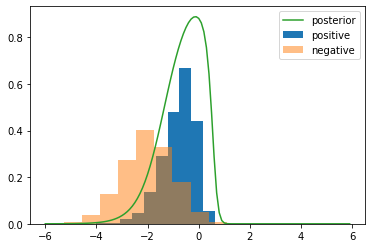

In [129]:
if DIM == 1:
    plt.hist(xUnlabeledTrain[yPNTrain].ravel(),density=True,label="positive")
    plt.hist(xUnlabeledTrain[~yPNTrain].ravel(),density=True,alpha=.5,label="negative")
    rng = np.arange(-6,6,.1)
    plt.plot(rng, posterior(rng),label="posterior")
    plt.legend()
elif DIM == 2:
    plt.scatter(*xUnlabeledVal[yPNVal].T)
    plt.scatter(*xUnlabeledVal[~yPNVal].T)

In [130]:
from tensorflow.keras import initializers
def makeEncoder(input_dim, h_dim,latent_dim,):
    encoderInput = layers.Input(shape=(input_dim,))
    x = layers.Dense(h_dim,activation="relu",
                     kernel_initializer=initializers.RandomNormal(stddev=0.01),
                     bias_initializer=initializers.Zeros()
)(encoderInput)
    x = layers.Dense(h_dim,activation="relu",
                     kernel_initializer=initializers.RandomNormal(stddev=0.01),
                     bias_initializer=initializers.Zeros())(x)
    x = layers.Dense(h_dim,activation="relu",
                     kernel_initializer=initializers.RandomNormal(stddev=0.01),
                     bias_initializer=initializers.Zeros())(x)
    z = layers.Dense(latent_dim,
                     kernel_initializer=initializers.RandomNormal(stddev=0.01),
                     bias_initializer=initializers.Zeros(),
                     activation=None)(x)
    encoder = tf.keras.Model(encoderInput,z,name="encoder")
    return encoder

def makeDecoder(input_dim, h_dim,latent_dim):
    decoderInput = layers.Input(shape=(latent_dim))
    x = layers.Dense(h_dim,activation="relu",
                     kernel_initializer=initializers.RandomNormal(stddev=0.01),
                     bias_initializer=initializers.Zeros())(decoderInput)
    x = layers.Dense(h_dim,activation="relu",
                     kernel_initializer=initializers.RandomNormal(stddev=0.01),
                     bias_initializer=initializers.Zeros())(x)
    x = layers.Dense(h_dim,activation="relu",
                     kernel_initializer=initializers.RandomNormal(stddev=0.01),
                     bias_initializer=initializers.Zeros())(x)
    xHat = layers.Dense(input_dim,activation=None,
                     kernel_initializer=initializers.RandomNormal(stddev=0.01),
                     bias_initializer=initializers.Zeros())(x)
    decoder = tf.keras.Model(decoderInput,xHat,name="decoder")
    return decoder

def makeDiscriminator(h_dim, latent_dim):
    discriminatorInput = layers.Input(shape=(latent_dim))
    x = layers.Dense(h_dim,activation="relu",
                     kernel_initializer=initializers.RandomNormal(stddev=0.01),
                     bias_initializer=initializers.Zeros())(discriminatorInput)
    x = layers.Dense(h_dim,activation="relu",
                     kernel_initializer=initializers.RandomNormal(stddev=0.01),
                     bias_initializer=initializers.Zeros())(x)
    x = layers.Dense(h_dim,activation="relu",
                     kernel_initializer=initializers.RandomNormal(stddev=0.01),
                     bias_initializer=initializers.Zeros())(x)
    decision = layers.Dense(1,activation=None,
                     kernel_initializer=initializers.RandomNormal(stddev=0.01),
                     bias_initializer=initializers.Zeros())(x)
    discriminator = tf.keras.Model(discriminatorInput, decision,name="discriminator")
    return discriminator

In [170]:
h_dim = 128
latent_dim = 1

In [184]:
class AdversarialAutoencoder(tf.keras.Model):
    def __init__(self, encoder,decoder,discriminator,lr=.0005,**kwargs):
        super(AdversarialAutoencoder,self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.generative_loss_tracker = tf.keras.metrics.Mean(name="generative_loss")
        self.discriminative_loss_tracker = tf.keras.metrics.Mean(name="discriminative_loss")
        self.discrimiator_auc = tf.keras.metrics.AUC(name="disc_auc",from_logits=True)
        self.m = np.stack([
            np.zeros(latent_dim) + 10,
            np.zeros(latent_dim) - 10
        ])
        self.s = np.stack([
            np.eye(latent_dim),
            np.eye(latent_dim)
        ]) * 5
        self.alpha = .5
        self.lr=lr
        self.NComps = 2
        self.ae_optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        self.gen_optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        self.disc_optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.generative_loss_tracker,
            self.discriminative_loss_tracker,
        ]
    
    def train_step(self,batch):
        #### Auto-encoder Step ######
        with tf.GradientTape() as ae_tape:
           
            z = self.encoder(batch)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.keras.losses.MeanAbsoluteError()(batch,reconstruction)
        reconstruction_grads = ae_tape.gradient(reconstruction_loss,
                                                self.encoder.trainable_weights + self.decoder.trainable_weights)
        self.ae_optimizer.apply_gradients(zip(reconstruction_grads,
                                              self.encoder.trainable_weights + self.decoder.trainable_weights))
        #### Discriminator Step #####
        with tf.GradientTape() as disc_tape:
            mixingProportions = [self.alpha,1-self.alpha]
            real_distribution = np.concatenate([
                np.random.multivariate_normal(self.m[i],
                                              self.s[i],
                                              size=int(1000 * mixingProportions[i]))
            for i in range(self.NComps)])
            real_decisions = self.discriminator(real_distribution)
            fake_decisions = self.discriminator(self.encoder(batch))
            labels = tf.concat([tf.ones_like(real_decisions),tf.zeros_like(fake_decisions)],axis=0)
            logits = tf.concat([real_decisions,fake_decisions],axis=0)
            discriminator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels,logits))
        disc_grads = disc_tape.gradient(discriminator_loss, self.discriminator.trainable_weights)
        self.disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_weights))
        
        ##### Generative Step #######
        with tf.GradientTape() as gen_tape:
            z = self.encoder(batch)
            fake_decisions = self.discriminator(z)
            fake_labels = tf.ones_like(fake_decisions)
            generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(fake_labels, fake_decisions))
        gen_grads = gen_tape.gradient(generator_loss,self.encoder.trainable_weights)
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.encoder.trainable_weights))
        
        ############ Update metrics ##########################
        self.total_loss_tracker.update_state(reconstruction_loss + generator_loss + discriminator_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.generative_loss_tracker.update_state(generator_loss)
        self.discriminative_loss_tracker.update_state(discriminator_loss)
        self.discrimiator_auc.update_state(labels,logits)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "generative_loss" : self.generative_loss_tracker.result(),
            "discriminator_loss" : self.discriminative_loss_tracker.result(),
            "discriminator_auc" : self.discrimiator_auc.result()
            
        }

In [185]:
encoder = makeEncoder(xUnlabeledTrain.shape[1],h_dim,latent_dim)

encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 1)]               0         
                                                                 
 dense_144 (Dense)           (None, 128)               256       
                                                                 
 dense_145 (Dense)           (None, 128)               16512     
                                                                 
 dense_146 (Dense)           (None, 128)               16512     
                                                                 
 dense_147 (Dense)           (None, 1)                 129       
                                                                 
Total params: 33,409
Trainable params: 33,409
Non-trainable params: 0
_________________________________________________________________


In [186]:
decoder = makeDecoder(xUnlabeledTrain.shape[1],h_dim,latent_dim)

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 1)]               0         
                                                                 
 dense_148 (Dense)           (None, 128)               256       
                                                                 
 dense_149 (Dense)           (None, 128)               16512     
                                                                 
 dense_150 (Dense)           (None, 128)               16512     
                                                                 
 dense_151 (Dense)           (None, 1)                 129       
                                                                 
Total params: 33,409
Trainable params: 33,409
Non-trainable params: 0
_________________________________________________________________


In [187]:
discriminator = makeDiscriminator(h_dim, latent_dim)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 1)]               0         
                                                                 
 dense_152 (Dense)           (None, 128)               256       
                                                                 
 dense_153 (Dense)           (None, 128)               16512     
                                                                 
 dense_154 (Dense)           (None, 128)               16512     
                                                                 
 dense_155 (Dense)           (None, 1)                 129       
                                                                 
Total params: 33,409
Trainable params: 33,409
Non-trainable params: 0
_________________________________________________________________


In [188]:
ae = AdversarialAutoencoder(encoder,decoder,discriminator)

In [189]:
ae.compile()



90/90 [==============================] - 1s 14ms/step - loss: 0.5455 - reconstruction_loss: 0.1388 - generative_loss: 0.1719 - discriminator_loss: 0.2509 - discriminator_auc: 0.5684


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


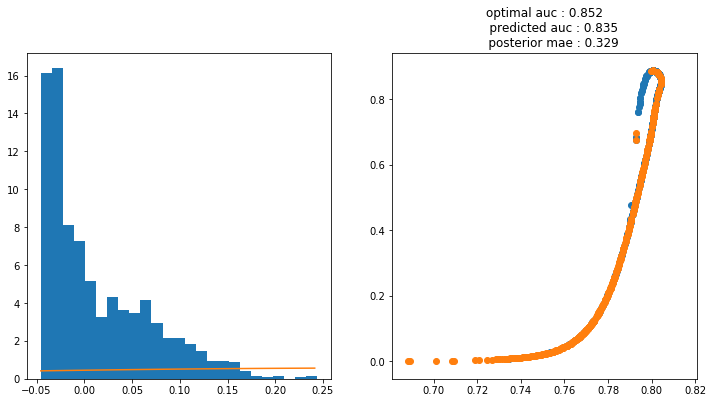


90/90 [==============================] - 1s 14ms/step - loss: 0.6844 - reconstruction_loss: 0.2826 - generative_loss: 0.1615 - discriminator_loss: 0.2626 - discriminator_auc: 0.6560


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


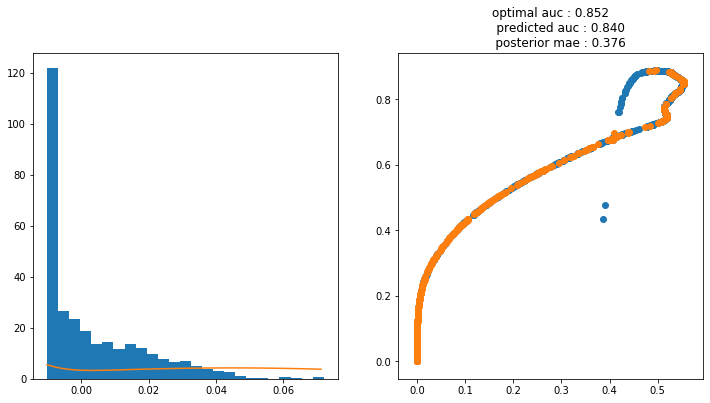


90/90 [==============================] - 1s 15ms/step - loss: 0.7496 - reconstruction_loss: 0.3485 - generative_loss: 0.1742 - discriminator_loss: 0.2654 - discriminator_auc: 0.7029


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


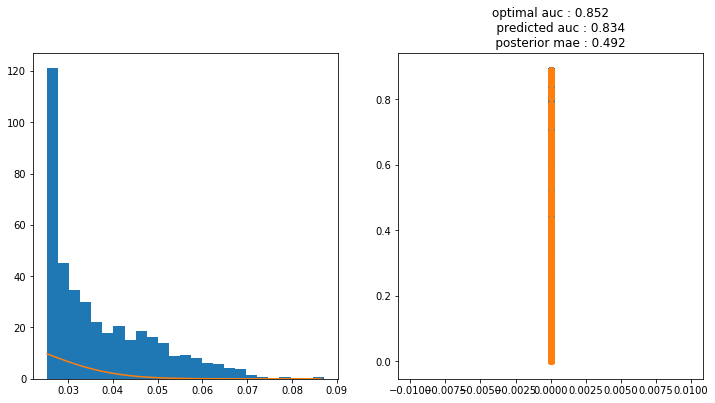


90/90 [==============================] - 1s 15ms/step - loss: 0.8078 - reconstruction_loss: 0.2783 - generative_loss: 0.1823 - discriminator_loss: 0.2895 - discriminator_auc: 0.6830


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


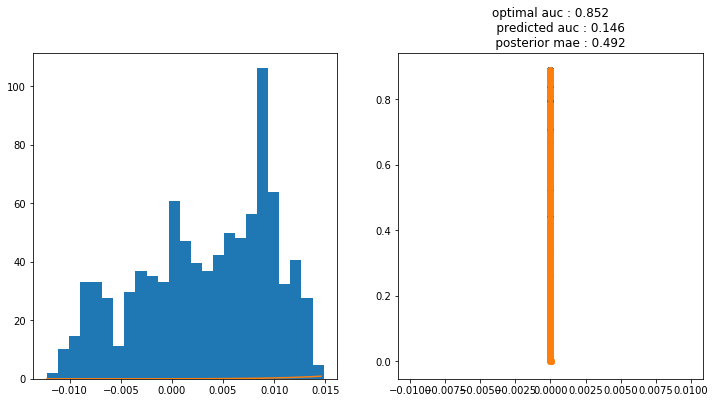


90/90 [==============================] - 1s 13ms/step - loss: 0.6146 - reconstruction_loss: 0.1402 - generative_loss: 0.1502 - discriminator_loss: 0.3240 - discriminator_auc: 0.6525


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


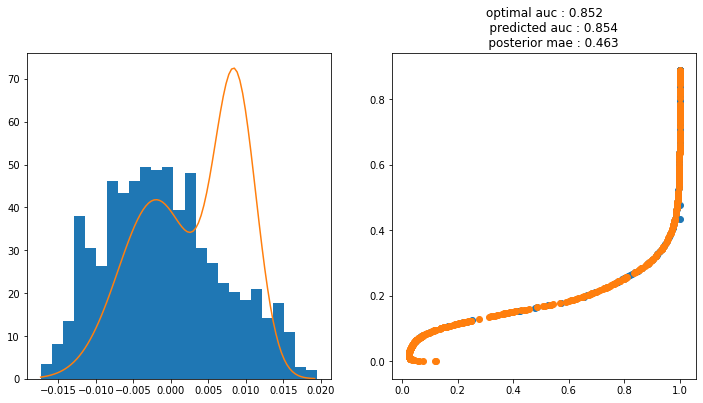


90/90 [==============================] - 1s 14ms/step - loss: 0.5231 - reconstruction_loss: 0.1198 - generative_loss: 0.1313 - discriminator_loss: 0.3205 - discriminator_auc: 0.6287


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


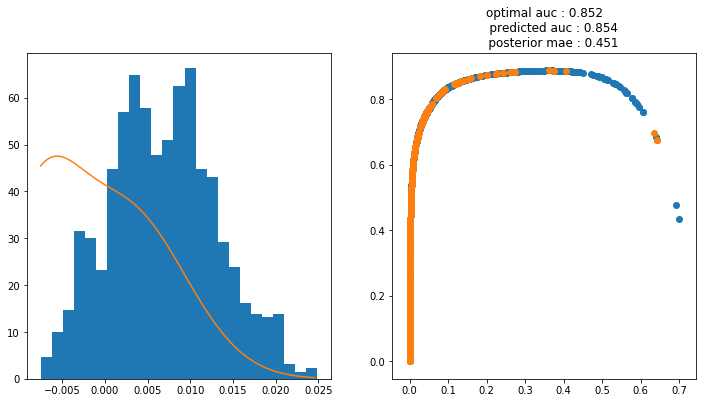


90/90 [==============================] - 1s 11ms/step - loss: 0.5419 - reconstruction_loss: 0.1190 - generative_loss: 0.1228 - discriminator_loss: 0.3058 - discriminator_auc: 0.6132


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


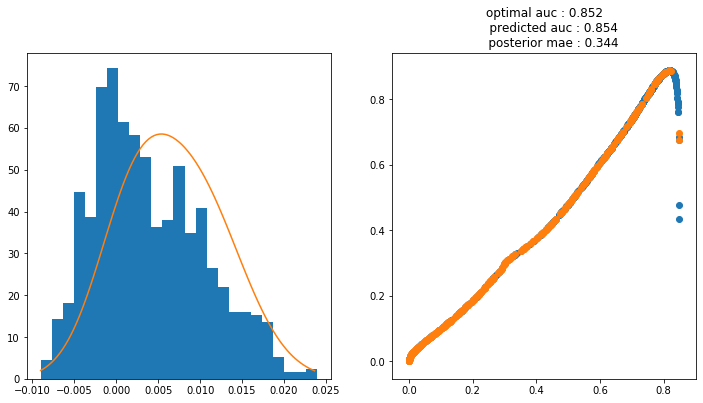


90/90 [==============================] - 1s 11ms/step - loss: 0.5136 - reconstruction_loss: 0.0886 - generative_loss: 0.1200 - discriminator_loss: 0.3039 - discriminator_auc: 0.6028


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


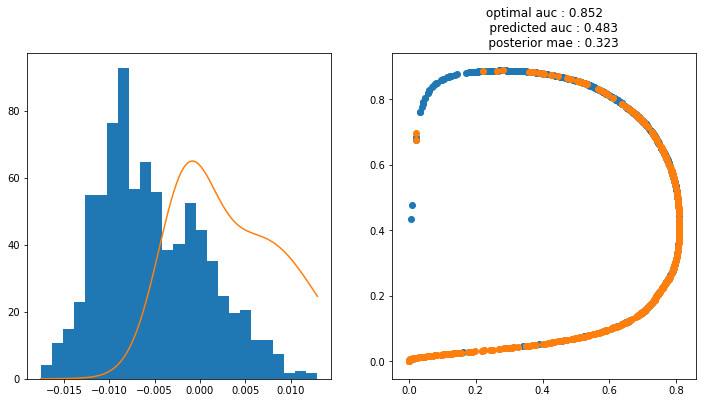


90/90 [==============================] - 1s 11ms/step - loss: 0.5780 - reconstruction_loss: 0.1444 - generative_loss: 0.1176 - discriminator_loss: 0.3095 - discriminator_auc: 0.5936


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


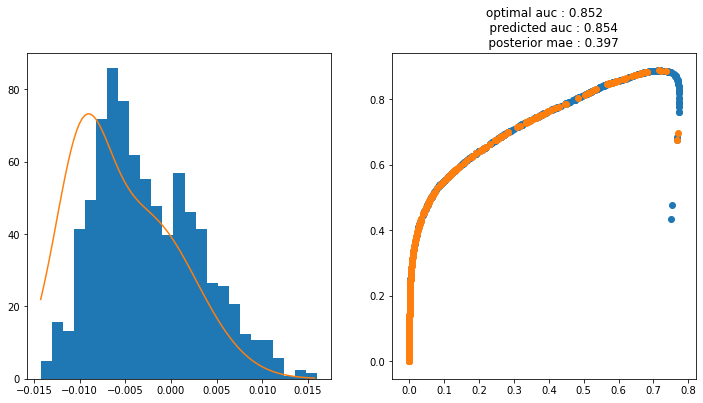


90/90 [==============================] - 1s 11ms/step - loss: 0.5246 - reconstruction_loss: 0.1120 - generative_loss: 0.1158 - discriminator_loss: 0.3102 - discriminator_auc: 0.5853


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


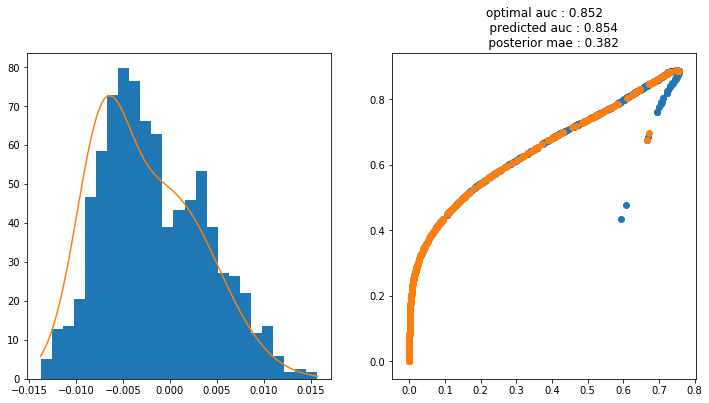


90/90 [==============================] - 1s 12ms/step - loss: 0.5820 - reconstruction_loss: 0.1900 - generative_loss: 0.1155 - discriminator_loss: 0.3101 - discriminator_auc: 0.5780


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


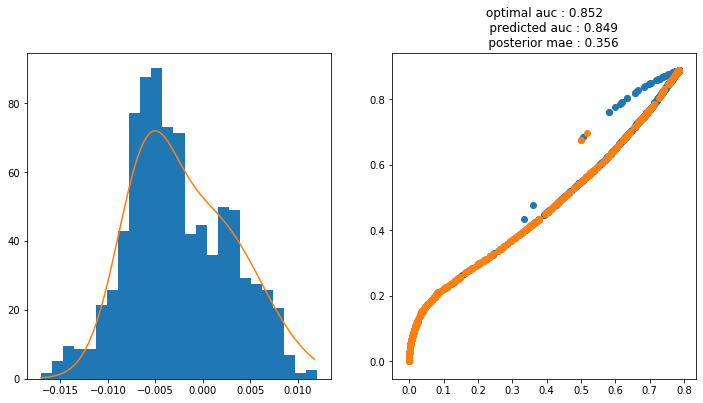


90/90 [==============================] - 1s 14ms/step - loss: 0.5309 - reconstruction_loss: 0.1137 - generative_loss: 0.1177 - discriminator_loss: 0.3050 - discriminator_auc: 0.5736


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


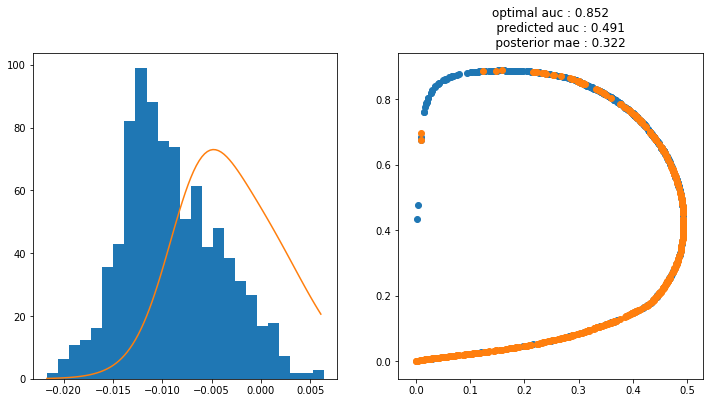


90/90 [==============================] - 1s 14ms/step - loss: 0.6055 - reconstruction_loss: 0.1622 - generative_loss: 0.1165 - discriminator_loss: 0.3051 - discriminator_auc: 0.5698


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


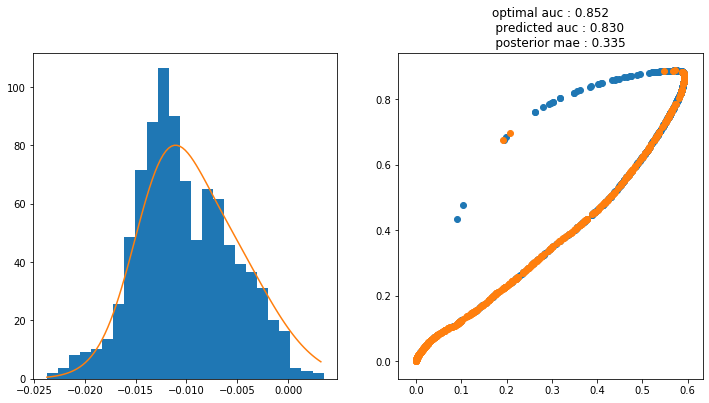


90/90 [==============================] - 1s 14ms/step - loss: 0.5971 - reconstruction_loss: 0.1450 - generative_loss: 0.1196 - discriminator_loss: 0.3034 - discriminator_auc: 0.5676


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


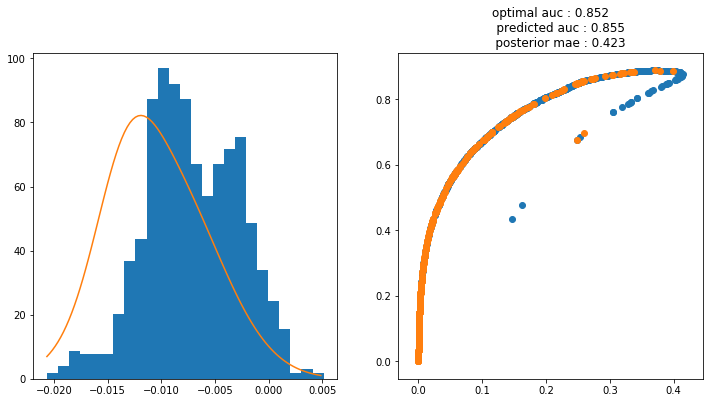


90/90 [==============================] - 1s 14ms/step - loss: 0.5916 - reconstruction_loss: 0.1589 - generative_loss: 0.1145 - discriminator_loss: 0.3092 - discriminator_auc: 0.5650


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


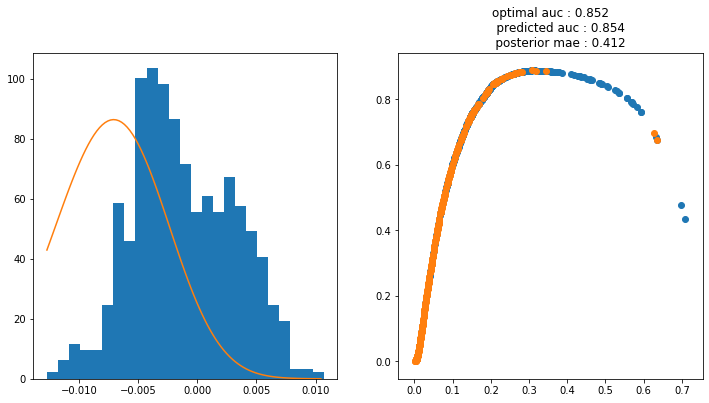


90/90 [==============================] - 1s 13ms/step - loss: 0.5013 - reconstruction_loss: 0.0986 - generative_loss: 0.1099 - discriminator_loss: 0.3107 - discriminator_auc: 0.5624


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


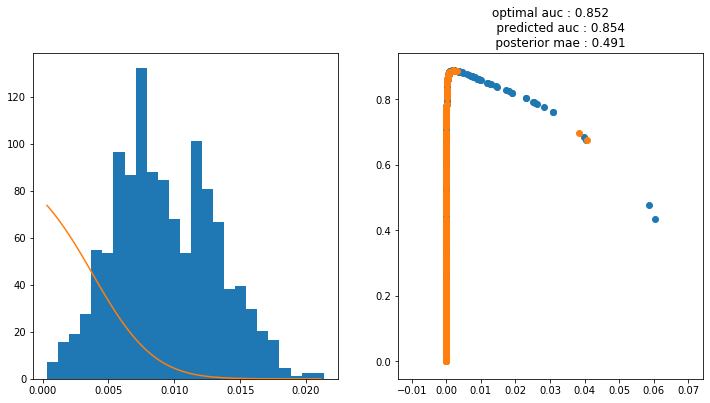


90/90 [==============================] - 1s 12ms/step - loss: 0.5310 - reconstruction_loss: 0.1475 - generative_loss: 0.1006 - discriminator_loss: 0.2984 - discriminator_auc: 0.5611


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


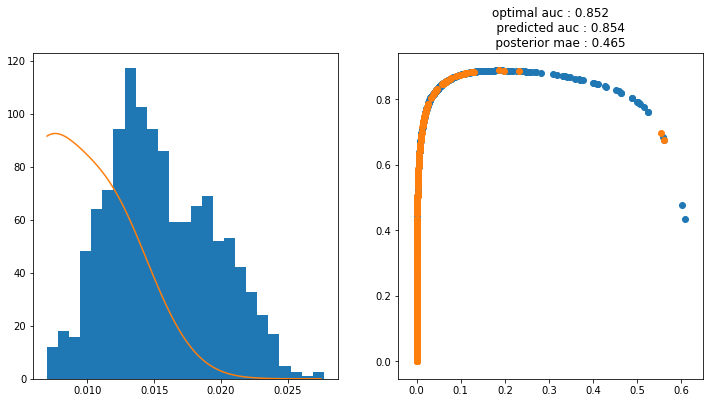


90/90 [==============================] - 1s 12ms/step - loss: 0.6054 - reconstruction_loss: 0.2014 - generative_loss: 0.1182 - discriminator_loss: 0.2918 - discriminator_auc: 0.5566


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


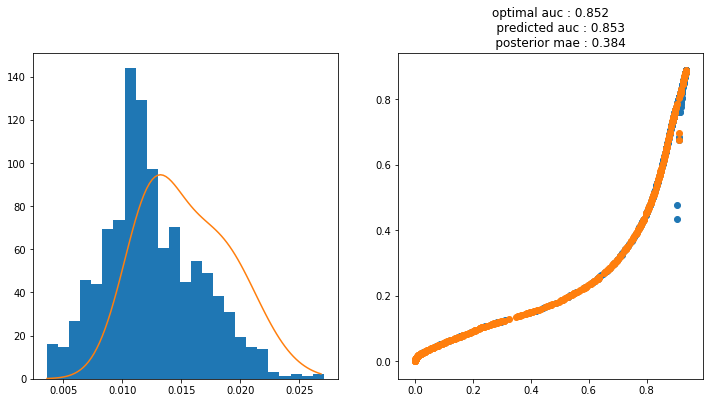


90/90 [==============================] - 1s 13ms/step - loss: 0.5996 - reconstruction_loss: 0.1890 - generative_loss: 0.1157 - discriminator_loss: 0.2930 - discriminator_auc: 0.5539


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


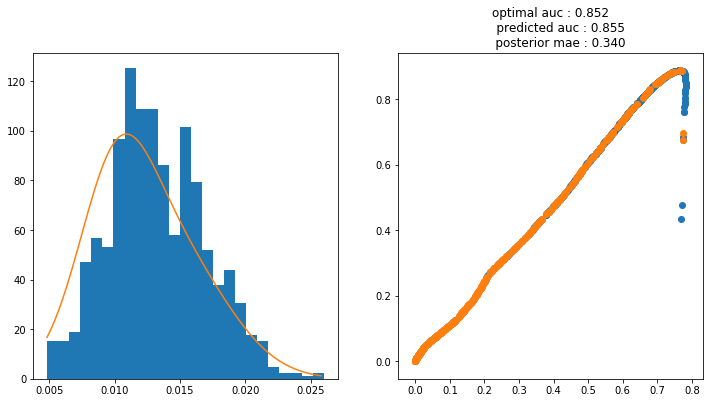


90/90 [==============================] - 1s 14ms/step - loss: 0.5298 - reconstruction_loss: 0.1421 - generative_loss: 0.1164 - discriminator_loss: 0.2941 - discriminator_auc: 0.5538


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


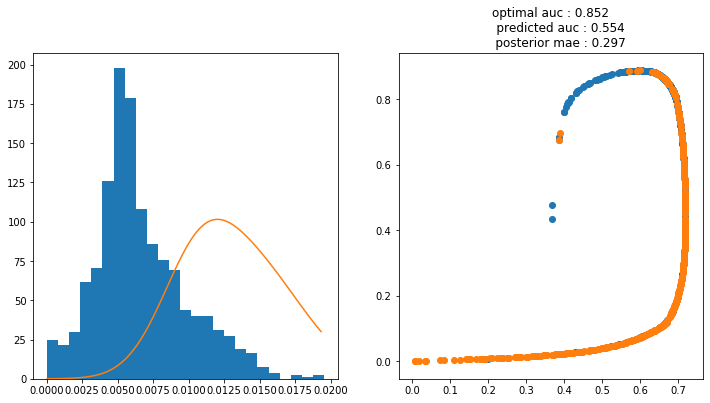


90/90 [==============================] - 1s 12ms/step - loss: 0.5392 - reconstruction_loss: 0.1364 - generative_loss: 0.0986 - discriminator_loss: 0.3059 - discriminator_auc: 0.5541


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


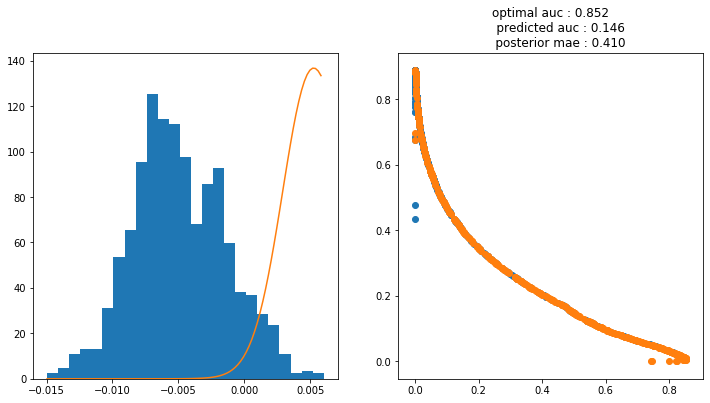


90/90 [==============================] - 1s 14ms/step - loss: 0.5041 - reconstruction_loss: 0.1103 - generative_loss: 0.1114 - discriminator_loss: 0.3078 - discriminator_auc: 0.5539


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


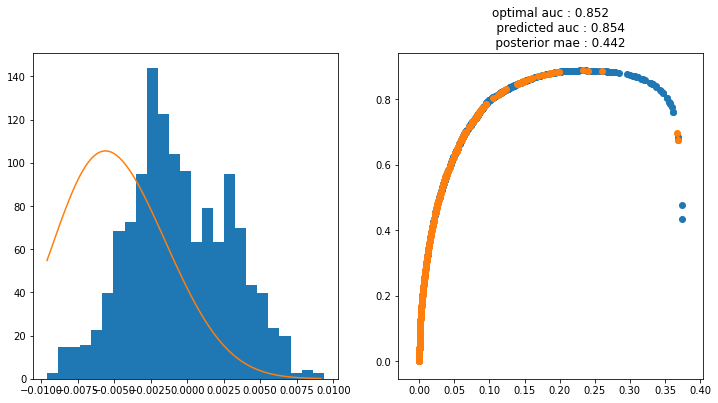


90/90 [==============================] - 1s 14ms/step - loss: 0.5115 - reconstruction_loss: 0.0966 - generative_loss: 0.1026 - discriminator_loss: 0.3096 - discriminator_auc: 0.5528


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


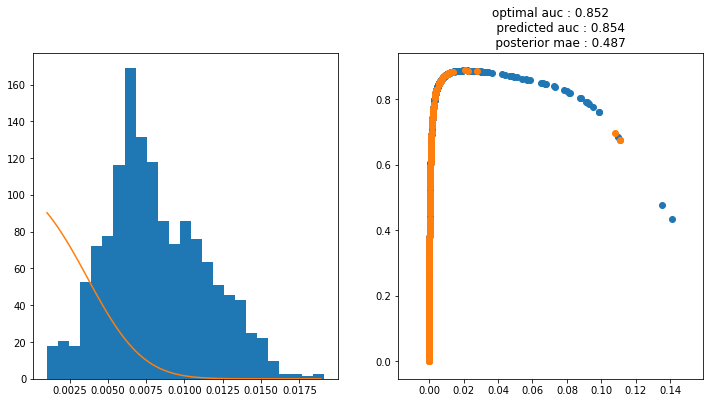


90/90 [==============================] - 1s 13ms/step - loss: 0.6142 - reconstruction_loss: 0.2052 - generative_loss: 0.1068 - discriminator_loss: 0.3004 - discriminator_auc: 0.5522


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


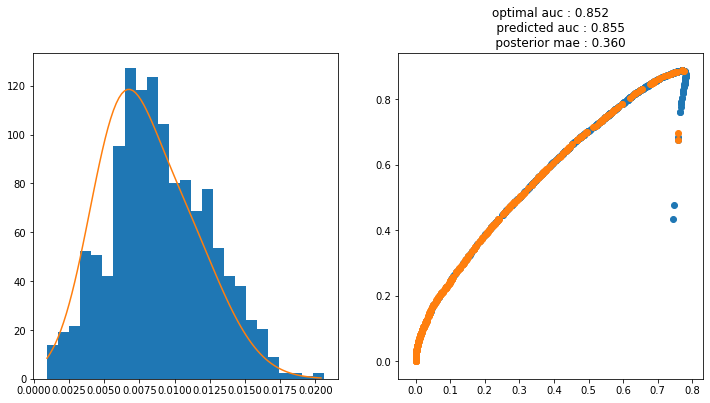


90/90 [==============================] - 1s 12ms/step - loss: 0.6116 - reconstruction_loss: 0.1526 - generative_loss: 0.1062 - discriminator_loss: 0.2984 - discriminator_auc: 0.5504


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


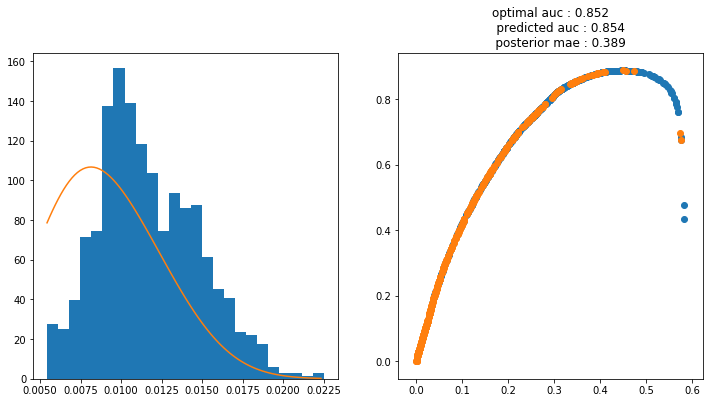


90/90 [==============================] - 1s 15ms/step - loss: 0.5121 - reconstruction_loss: 0.1626 - generative_loss: 0.1058 - discriminator_loss: 0.2978 - discriminator_auc: 0.5495


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


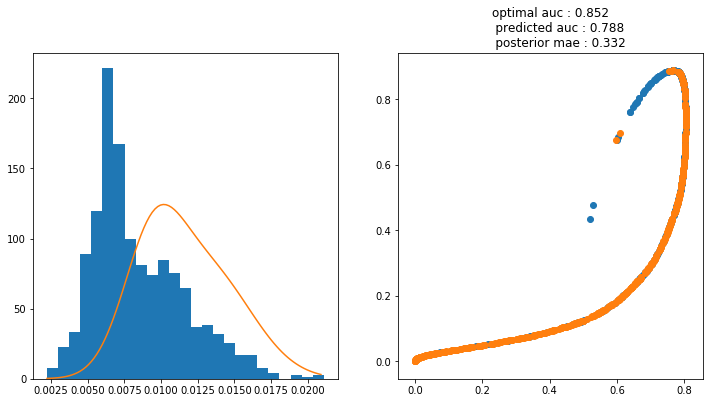


90/90 [==============================] - 1s 13ms/step - loss: 0.5698 - reconstruction_loss: 0.1962 - generative_loss: 0.1060 - discriminator_loss: 0.3035 - discriminator_auc: 0.5482


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


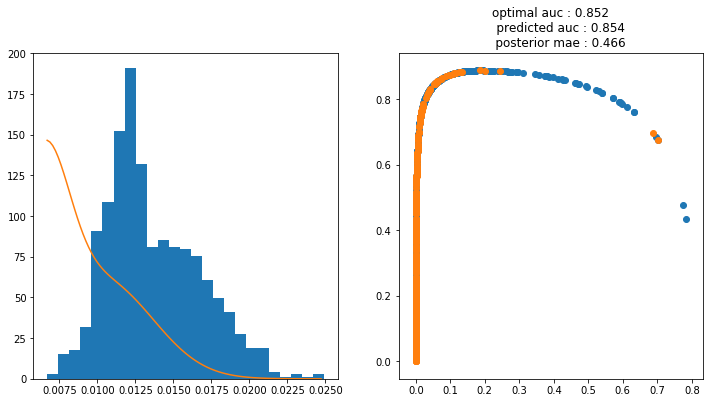


90/90 [==============================] - 1s 12ms/step - loss: 0.6908 - reconstruction_loss: 0.3427 - generative_loss: 0.1213 - discriminator_loss: 0.2971 - discriminator_auc: 0.5464


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


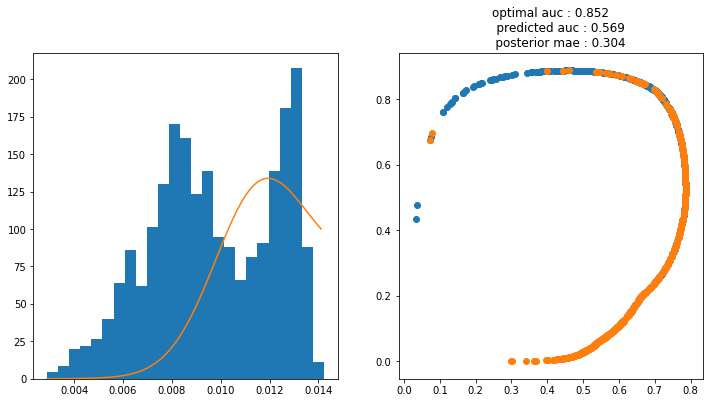


90/90 [==============================] - 1s 12ms/step - loss: 0.7039 - reconstruction_loss: 0.3818 - generative_loss: 0.1082 - discriminator_loss: 0.2952 - discriminator_auc: 0.5452


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


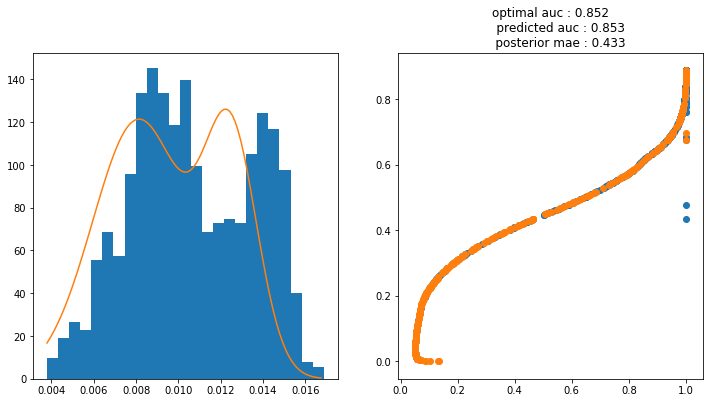


90/90 [==============================] - 1s 13ms/step - loss: 0.5795 - reconstruction_loss: 0.4947 - generative_loss: 0.1068 - discriminator_loss: 0.2992 - discriminator_auc: 0.5460


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


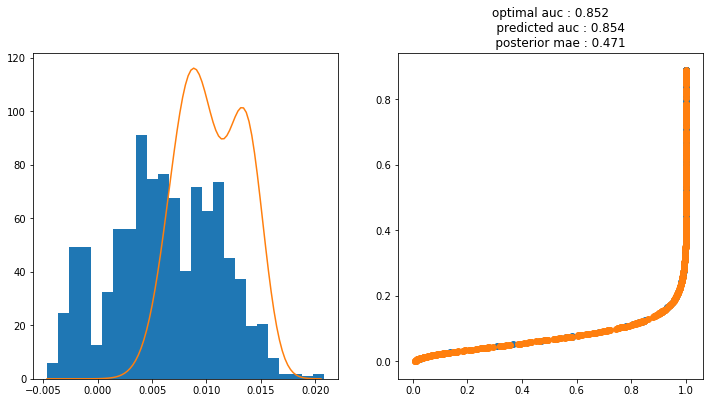


90/90 [==============================] - 1s 11ms/step - loss: 0.8104 - reconstruction_loss: 0.2421 - generative_loss: 0.0989 - discriminator_loss: 0.3023 - discriminator_auc: 0.5472


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


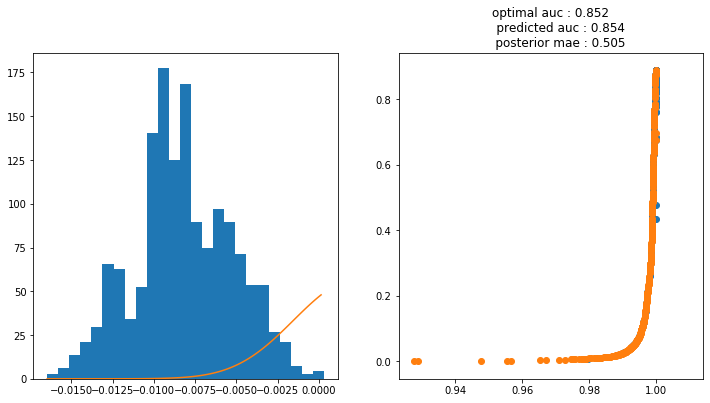


90/90 [==============================] - 1s 12ms/step - loss: 1.1076 - reconstruction_loss: 0.9753 - generative_loss: 0.1078 - discriminator_loss: 0.2997 - discriminator_auc: 0.5478


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


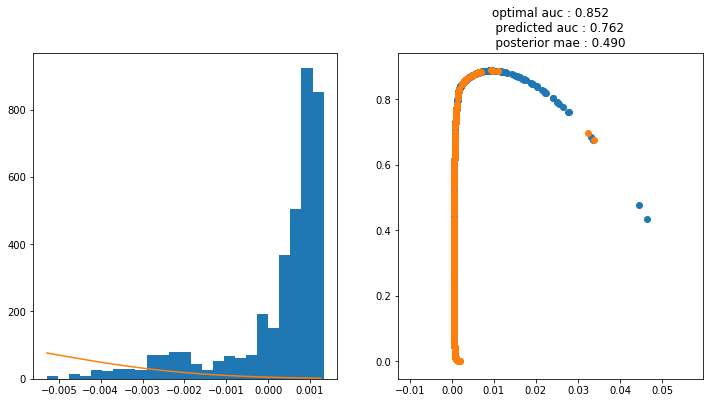


90/90 [==============================] - 1s 13ms/step - loss: 0.9561 - reconstruction_loss: 0.2822 - generative_loss: 0.1025 - discriminator_loss: 0.3020 - discriminator_auc: 0.5485


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


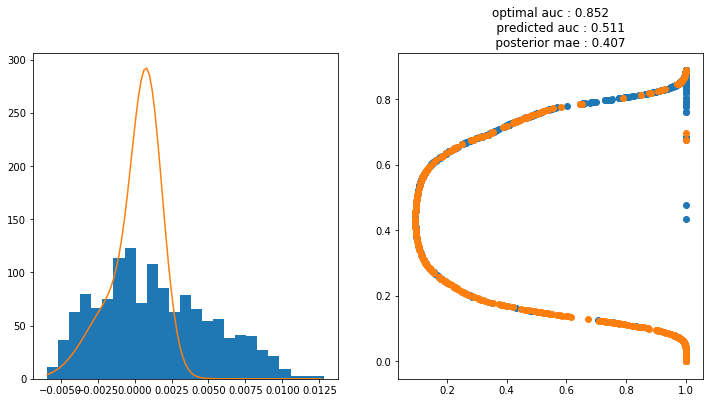


90/90 [==============================] - 1s 13ms/step - loss: 0.4834 - reconstruction_loss: 0.0881 - generative_loss: 0.1010 - discriminator_loss: 0.2990 - discriminator_auc: 0.5524


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


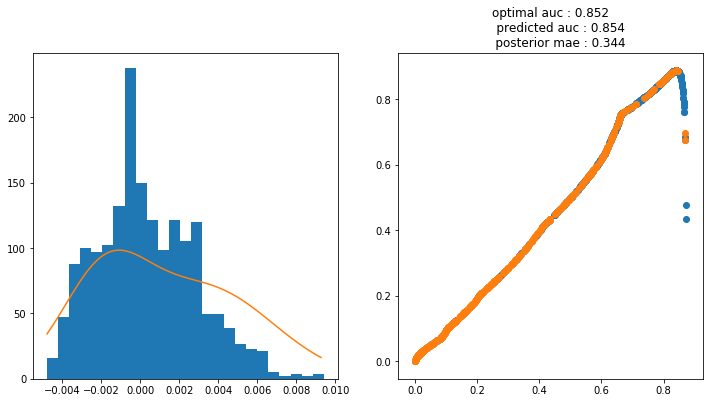


90/90 [==============================] - 1s 12ms/step - loss: 0.5165 - reconstruction_loss: 0.1501 - generative_loss: 0.1000 - discriminator_loss: 0.3003 - discriminator_auc: 0.5556


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


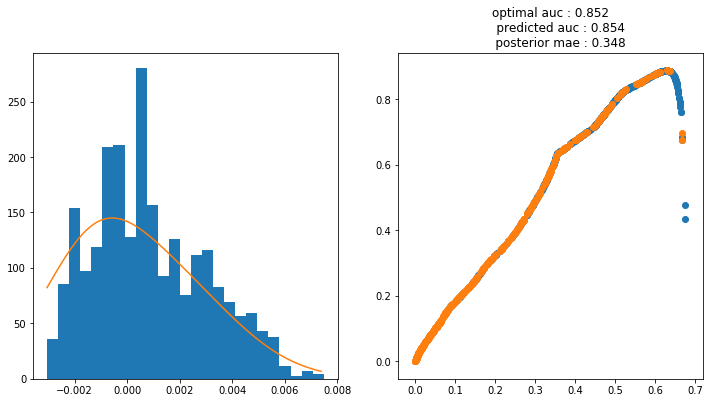


90/90 [==============================] - 1s 13ms/step - loss: 0.7056 - reconstruction_loss: 0.7835 - generative_loss: 0.1131 - discriminator_loss: 0.2992 - discriminator_auc: 0.5580


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


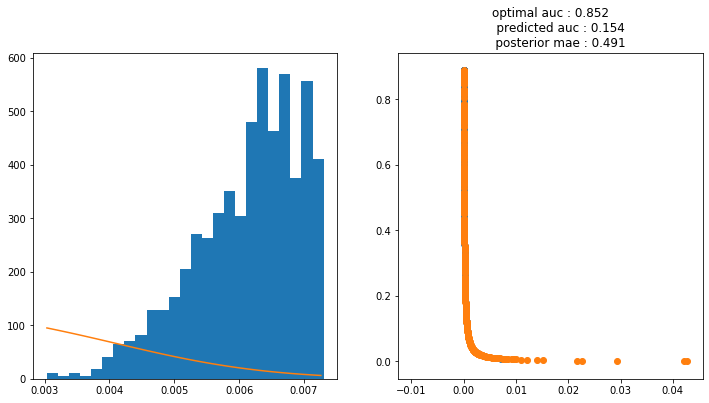


90/90 [==============================] - 1s 14ms/step - loss: 1.7579 - reconstruction_loss: 1.2881 - generative_loss: 0.1016 - discriminator_loss: 0.3026 - discriminator_auc: 0.5576


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


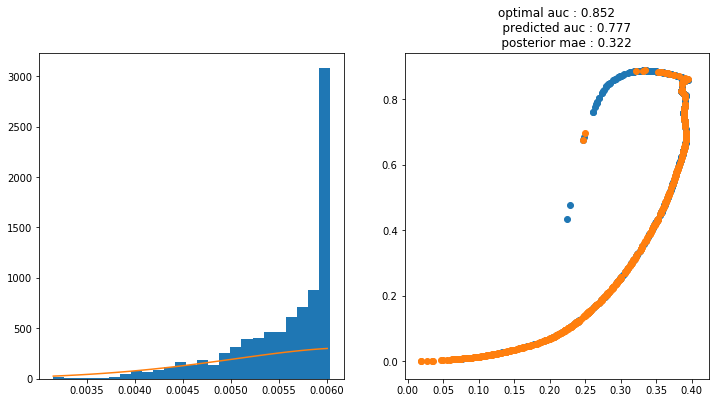


90/90 [==============================] - 1s 12ms/step - loss: 1.4403 - reconstruction_loss: 0.9841 - generative_loss: 0.0959 - discriminator_loss: 0.3021 - discriminator_auc: 0.5578


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


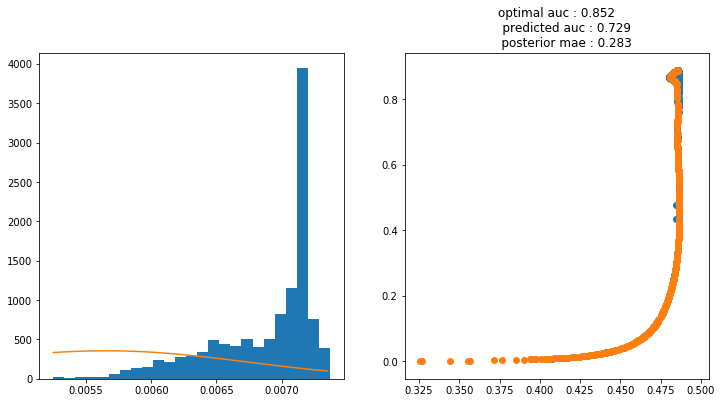


90/90 [==============================] - 1s 13ms/step - loss: 1.2671 - reconstruction_loss: 0.8512 - generative_loss: 0.0977 - discriminator_loss: 0.3078 - discriminator_auc: 0.5563


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


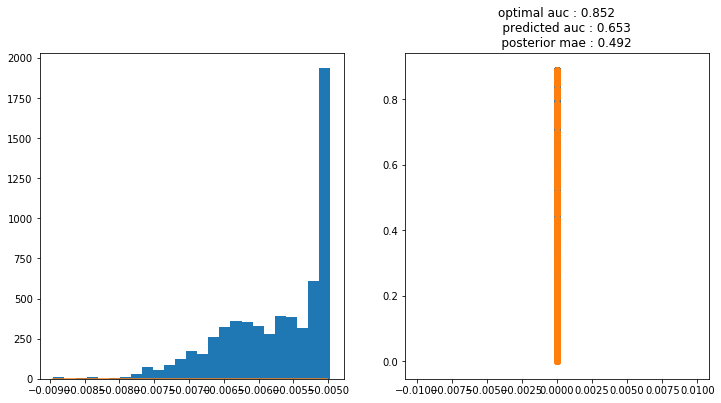


90/90 [==============================] - 1s 13ms/step - loss: 1.2341 - reconstruction_loss: 0.8344 - generative_loss: 0.0976 - discriminator_loss: 0.3030 - discriminator_auc: 0.5554


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


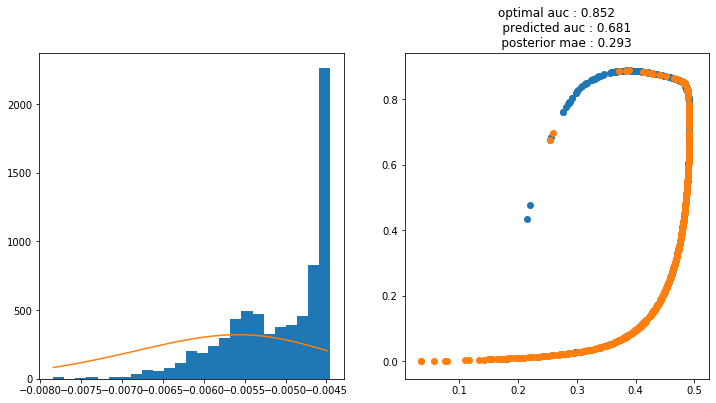


90/90 [==============================] - 1s 13ms/step - loss: 1.2365 - reconstruction_loss: 0.8343 - generative_loss: 0.0971 - discriminator_loss: 0.3103 - discriminator_auc: 0.5538


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


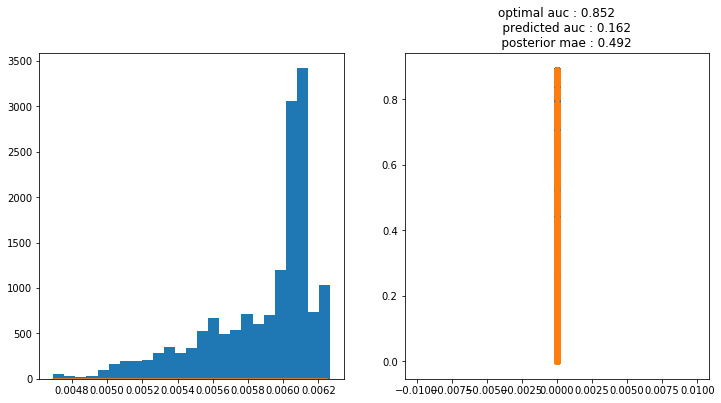


90/90 [==============================] - 1s 12ms/step - loss: 1.2519 - reconstruction_loss: 0.8342 - generative_loss: 0.0950 - discriminator_loss: 0.3026 - discriminator_auc: 0.5530


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


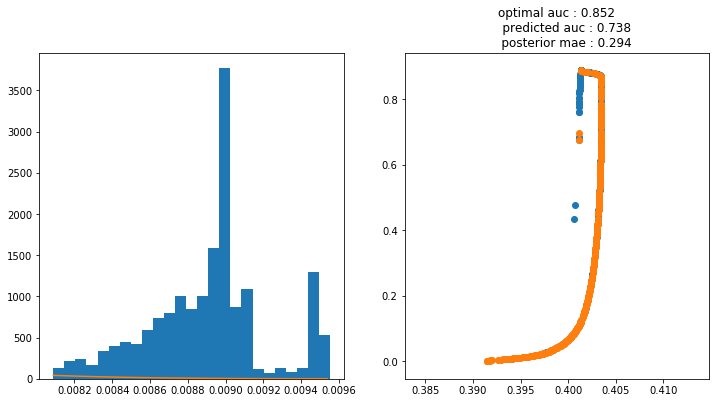


90/90 [==============================] - 1s 13ms/step - loss: 1.2377 - reconstruction_loss: 0.8341 - generative_loss: 0.1011 - discriminator_loss: 0.3019 - discriminator_auc: 0.5511


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


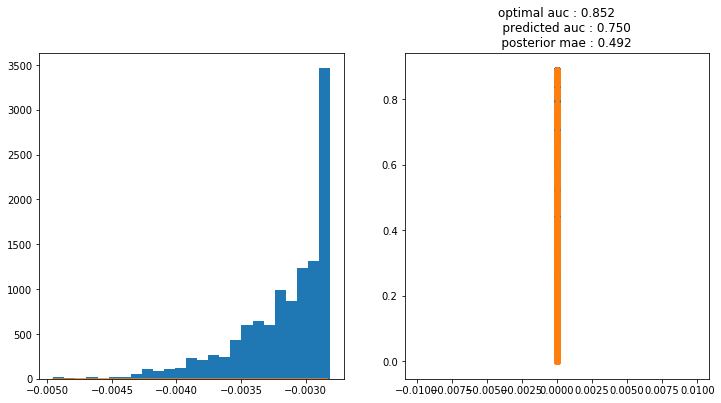


90/90 [==============================] - 1s 14ms/step - loss: 1.2340 - reconstruction_loss: 0.8346 - generative_loss: 0.0934 - discriminator_loss: 0.3061 - discriminator_auc: 0.5506


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


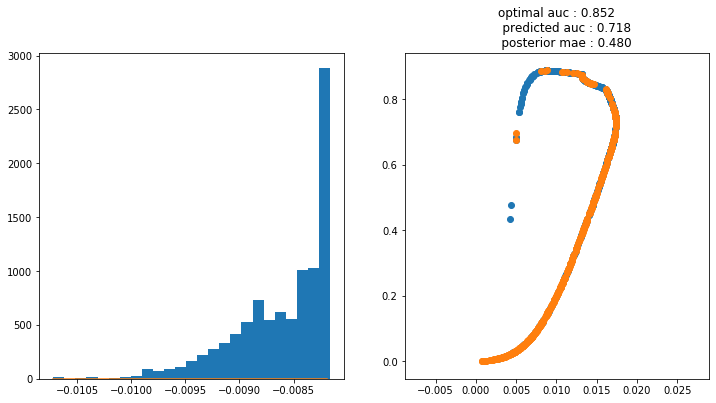


90/90 [==============================] - 1s 12ms/step - loss: 1.2434 - reconstruction_loss: 0.8343 - generative_loss: 0.1002 - discriminator_loss: 0.3014 - discriminator_auc: 0.5489


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


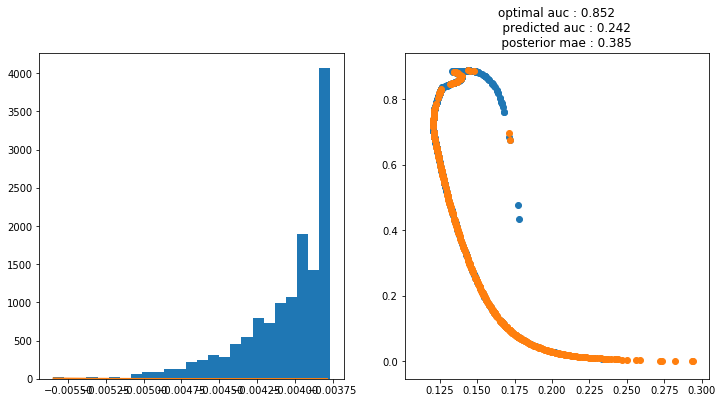


90/90 [==============================] - 1s 11ms/step - loss: 1.2435 - reconstruction_loss: 0.8344 - generative_loss: 0.0966 - discriminator_loss: 0.3104 - discriminator_auc: 0.5478


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


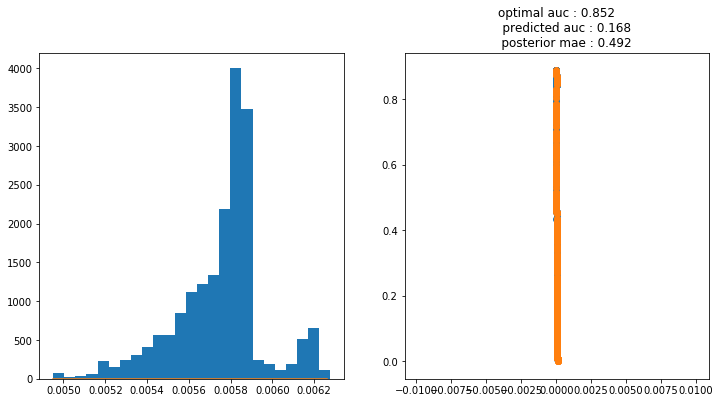


90/90 [==============================] - 1s 14ms/step - loss: 1.2368 - reconstruction_loss: 0.8345 - generative_loss: 0.0967 - discriminator_loss: 0.3028 - discriminator_auc: 0.5471


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


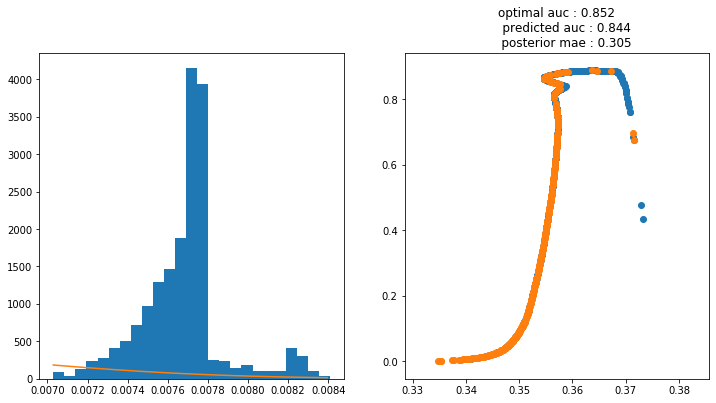


90/90 [==============================] - 1s 13ms/step - loss: 1.2319 - reconstruction_loss: 0.8347 - generative_loss: 0.0996 - discriminator_loss: 0.3042 - discriminator_auc: 0.5460


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


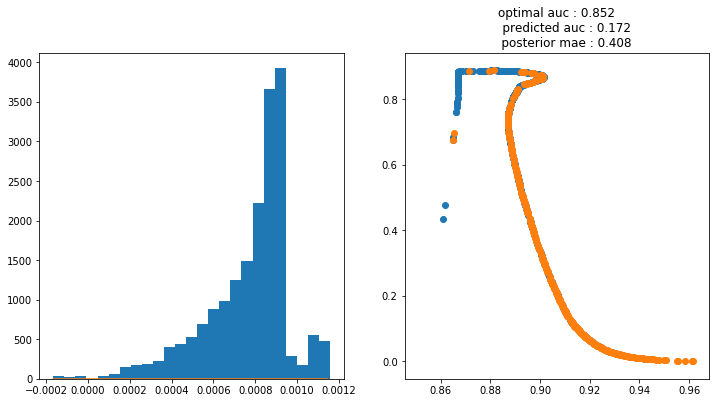


90/90 [==============================] - 1s 12ms/step - loss: 1.2347 - reconstruction_loss: 0.8343 - generative_loss: 0.0962 - discriminator_loss: 0.3097 - discriminator_auc: 0.5450


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


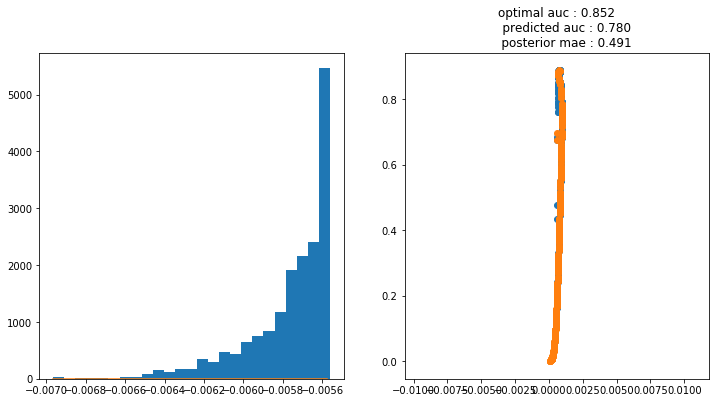


90/90 [==============================] - 1s 13ms/step - loss: 1.2231 - reconstruction_loss: 0.8343 - generative_loss: 0.0946 - discriminator_loss: 0.3027 - discriminator_auc: 0.5440


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


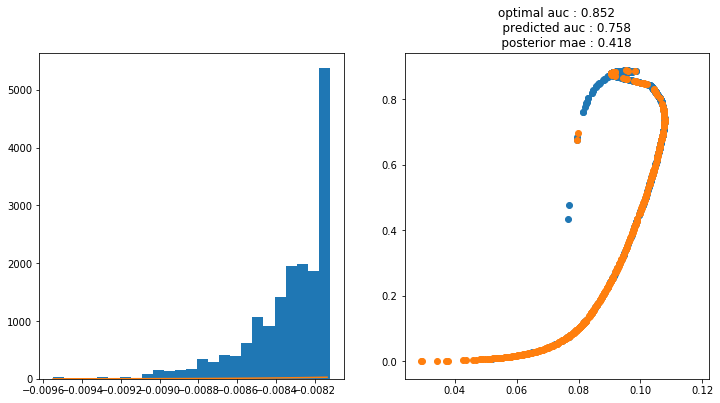


90/90 [==============================] - 1s 15ms/step - loss: 1.2284 - reconstruction_loss: 0.8342 - generative_loss: 0.0991 - discriminator_loss: 0.3005 - discriminator_auc: 0.5430


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


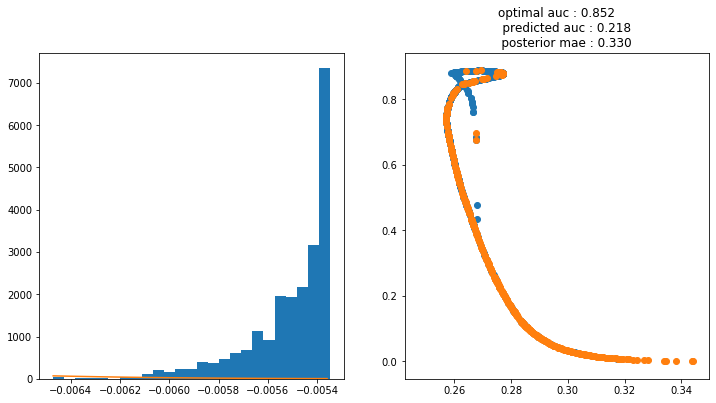


90/90 [==============================] - 1s 13ms/step - loss: 1.2462 - reconstruction_loss: 0.8346 - generative_loss: 0.0982 - discriminator_loss: 0.3082 - discriminator_auc: 0.5419


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


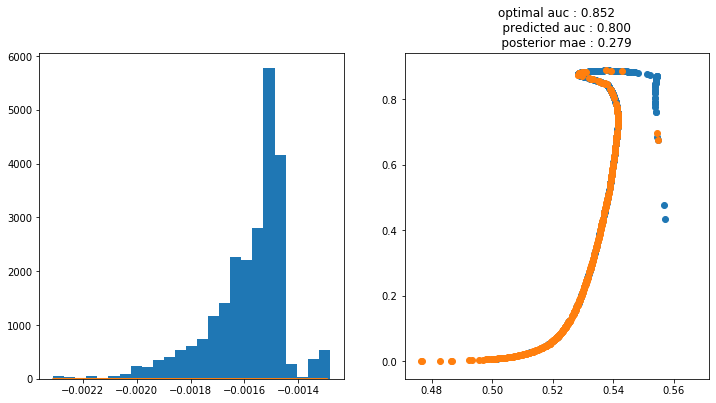


90/90 [==============================] - 1s 12ms/step - loss: 1.2353 - reconstruction_loss: 0.8346 - generative_loss: 0.0975 - discriminator_loss: 0.3095 - discriminator_auc: 0.5409


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


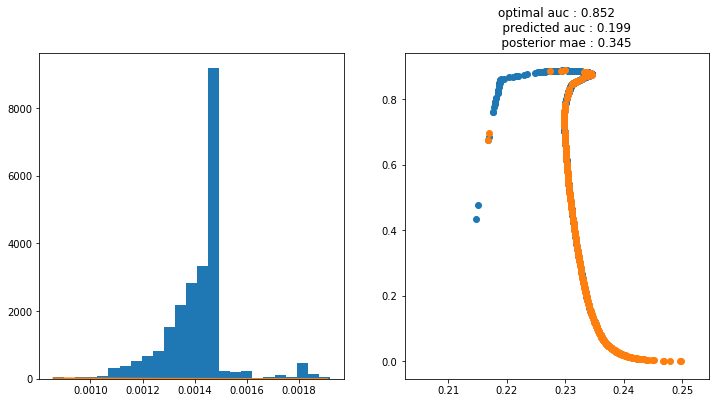


90/90 [==============================] - 1s 13ms/step - loss: 1.2293 - reconstruction_loss: 0.8348 - generative_loss: 0.0972 - discriminator_loss: 0.3078 - discriminator_auc: 0.5400


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


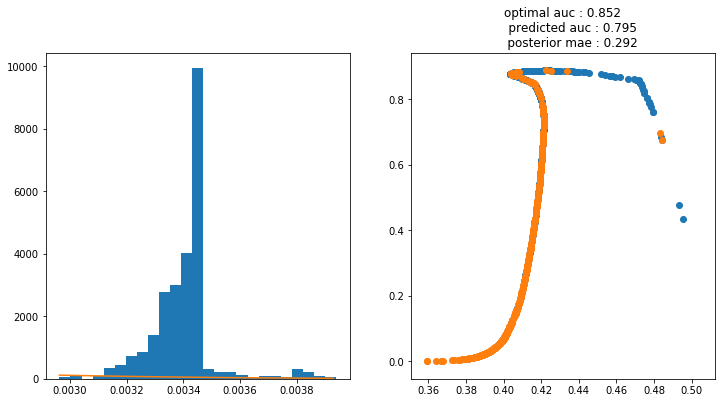


90/90 [==============================] - 1s 13ms/step - loss: 1.2419 - reconstruction_loss: 0.8347 - generative_loss: 0.0968 - discriminator_loss: 0.3058 - discriminator_auc: 0.5392


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


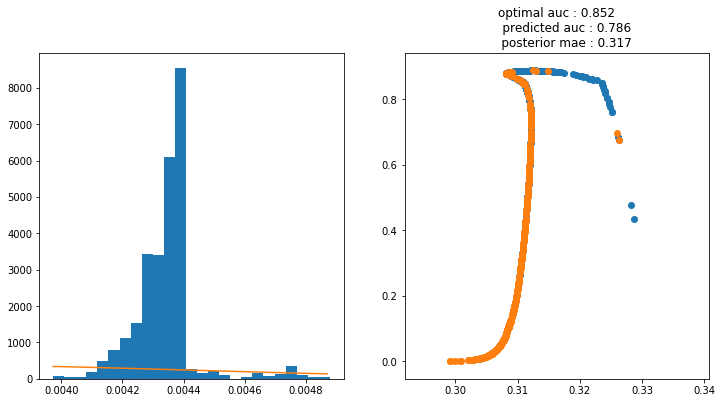


90/90 [==============================] - 1s 12ms/step - loss: 1.2301 - reconstruction_loss: 0.8347 - generative_loss: 0.0970 - discriminator_loss: 0.3045 - discriminator_auc: 0.5383


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


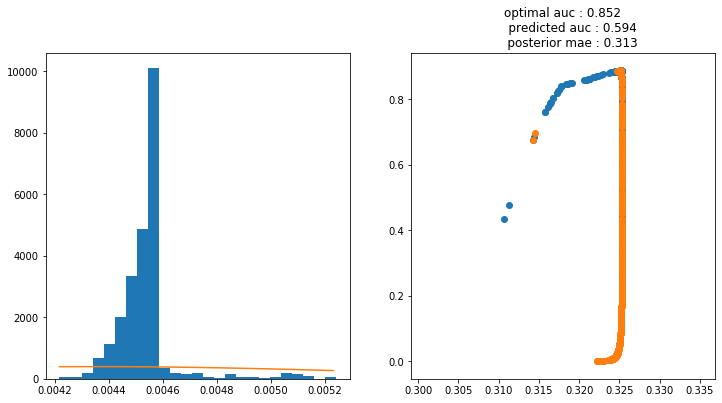


90/90 [==============================] - 1s 11ms/step - loss: 1.2251 - reconstruction_loss: 0.8347 - generative_loss: 0.0974 - discriminator_loss: 0.3041 - discriminator_auc: 0.5375


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


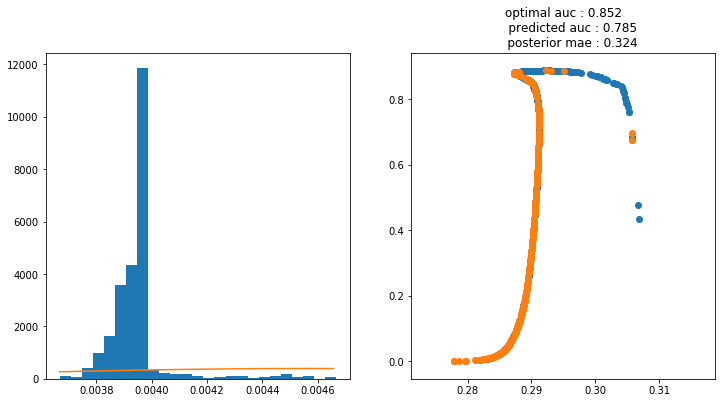


90/90 [==============================] - 1s 14ms/step - loss: 1.2274 - reconstruction_loss: 0.8348 - generative_loss: 0.0973 - discriminator_loss: 0.3048 - discriminator_auc: 0.5367


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


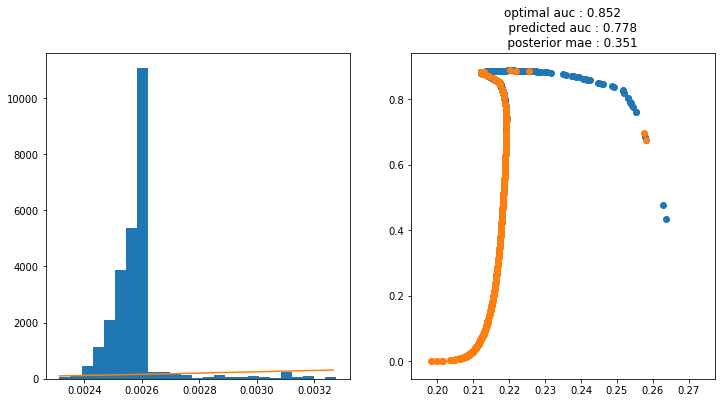


90/90 [==============================] - 1s 14ms/step - loss: 1.2282 - reconstruction_loss: 0.8348 - generative_loss: 0.0971 - discriminator_loss: 0.3062 - discriminator_auc: 0.5360


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


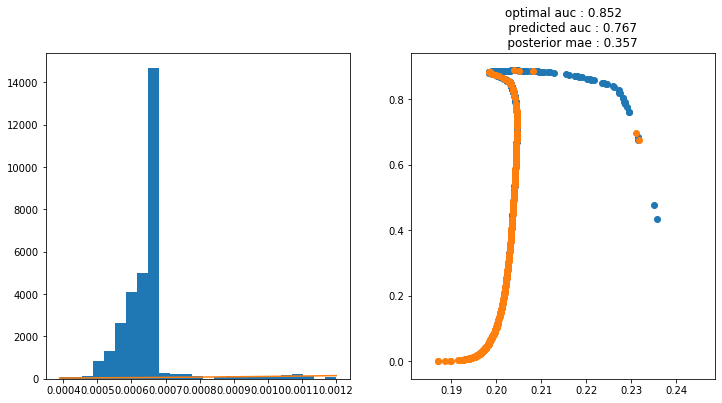


90/90 [==============================] - 1s 12ms/step - loss: 1.2325 - reconstruction_loss: 0.8345 - generative_loss: 0.0970 - discriminator_loss: 0.3076 - discriminator_auc: 0.5353


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


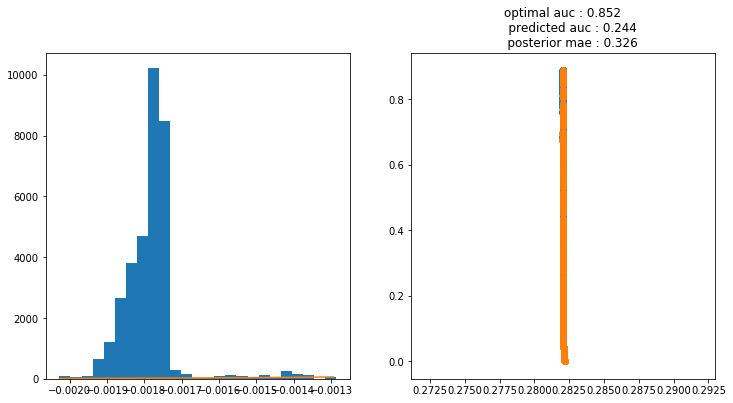


90/90 [==============================] - 1s 12ms/step - loss: 1.2326 - reconstruction_loss: 0.8347 - generative_loss: 0.0964 - discriminator_loss: 0.3084 - discriminator_auc: 0.5346


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


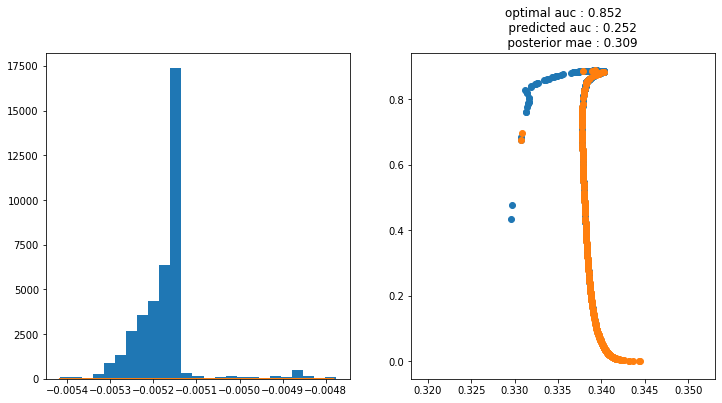


90/90 [==============================] - 1s 14ms/step - loss: 1.2354 - reconstruction_loss: 0.8345 - generative_loss: 0.0960 - discriminator_loss: 0.3069 - discriminator_auc: 0.5339


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


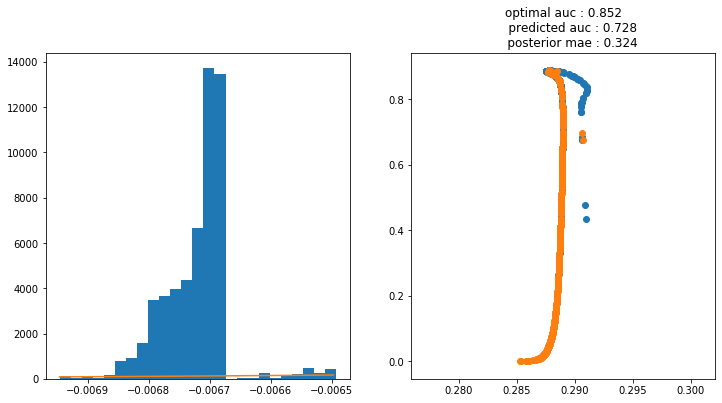


90/90 [==============================] - 1s 14ms/step - loss: 1.2388 - reconstruction_loss: 0.8345 - generative_loss: 0.0989 - discriminator_loss: 0.3016 - discriminator_auc: 0.5332


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


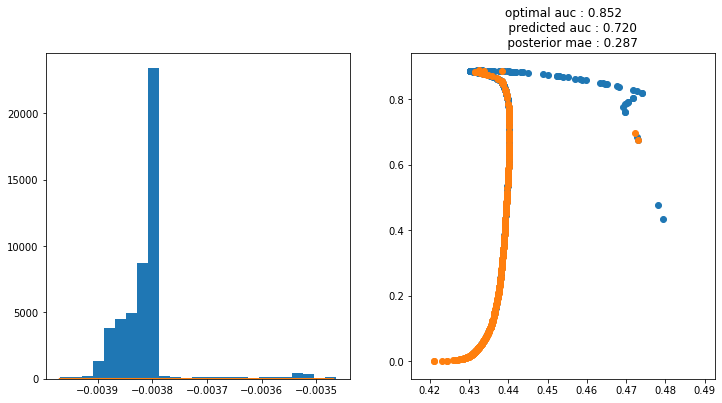


90/90 [==============================] - 1s 12ms/step - loss: 1.2329 - reconstruction_loss: 0.8348 - generative_loss: 0.0972 - discriminator_loss: 0.3043 - discriminator_auc: 0.5326


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


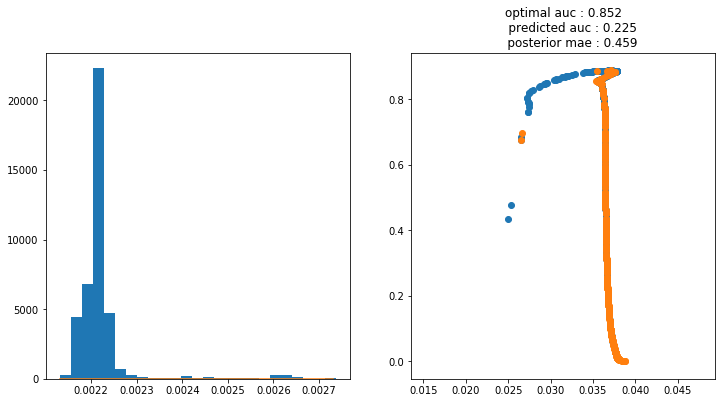


90/90 [==============================] - 1s 11ms/step - loss: 1.2295 - reconstruction_loss: 0.8345 - generative_loss: 0.0952 - discriminator_loss: 0.3080 - discriminator_auc: 0.5318


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


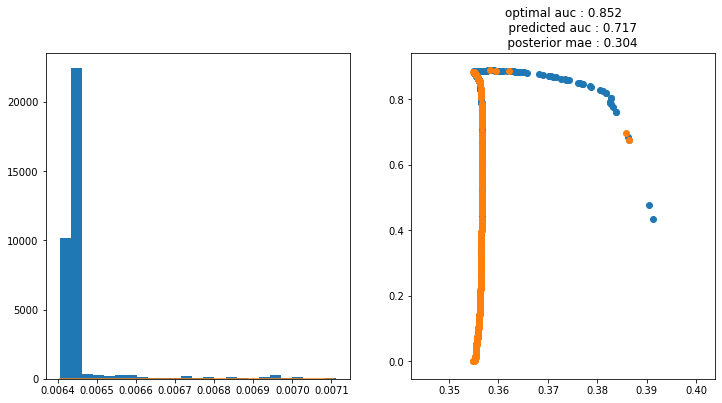


90/90 [==============================] - 1s 13ms/step - loss: 1.2466 - reconstruction_loss: 0.8348 - generative_loss: 0.0987 - discriminator_loss: 0.3016 - discriminator_auc: 0.5312


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


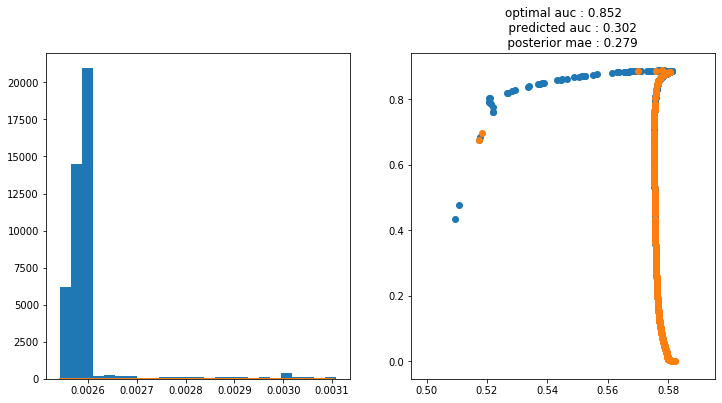


90/90 [==============================] - 1s 12ms/step - loss: 1.2333 - reconstruction_loss: 0.8346 - generative_loss: 0.0963 - discriminator_loss: 0.3055 - discriminator_auc: 0.5308


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


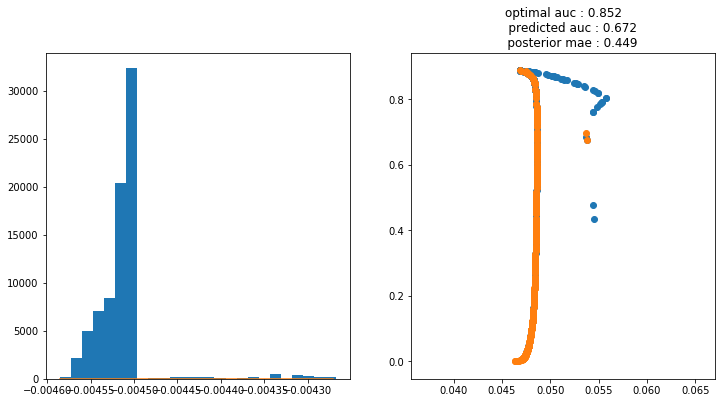


90/90 [==============================] - 1s 11ms/step - loss: 1.2270 - reconstruction_loss: 0.8346 - generative_loss: 0.0971 - discriminator_loss: 0.3067 - discriminator_auc: 0.5301


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


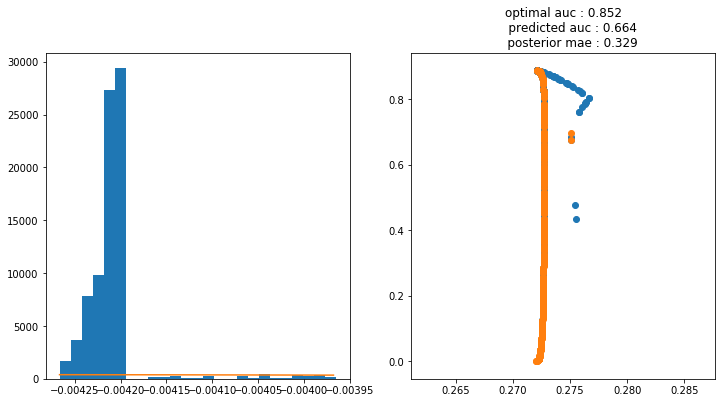


90/90 [==============================] - 1s 11ms/step - loss: 1.2316 - reconstruction_loss: 0.8348 - generative_loss: 0.0969 - discriminator_loss: 0.3034 - discriminator_auc: 0.5297


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


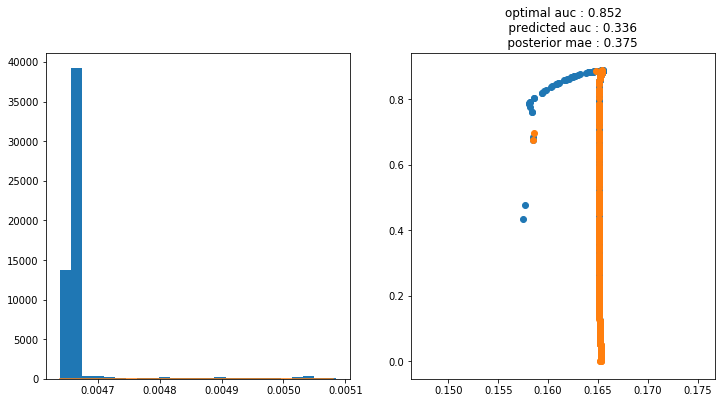


90/90 [==============================] - 1s 11ms/step - loss: 1.2340 - reconstruction_loss: 0.8347 - generative_loss: 0.0972 - discriminator_loss: 0.3058 - discriminator_auc: 0.5291


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


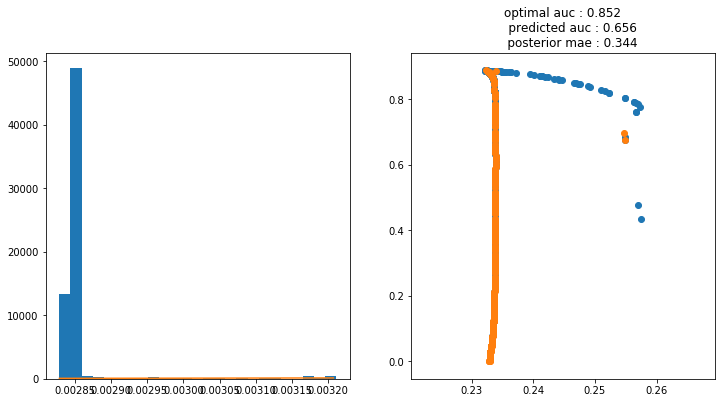


90/90 [==============================] - 1s 11ms/step - loss: 1.2347 - reconstruction_loss: 0.8348 - generative_loss: 0.0956 - discriminator_loss: 0.3050 - discriminator_auc: 0.5287


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


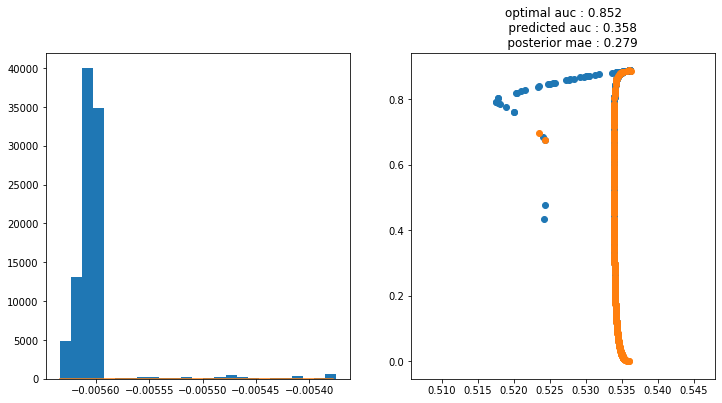


90/90 [==============================] - 1s 11ms/step - loss: 1.2362 - reconstruction_loss: 0.8346 - generative_loss: 0.0980 - discriminator_loss: 0.3037 - discriminator_auc: 0.5282


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


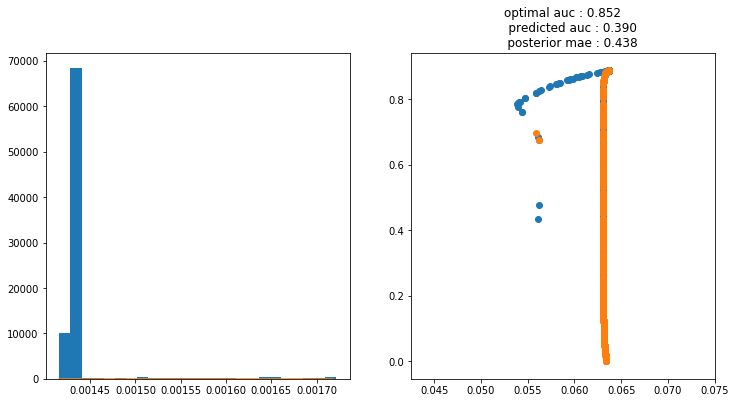


90/90 [==============================] - 1s 11ms/step - loss: 1.2362 - reconstruction_loss: 0.8347 - generative_loss: 0.0961 - discriminator_loss: 0.3073 - discriminator_auc: 0.5278


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


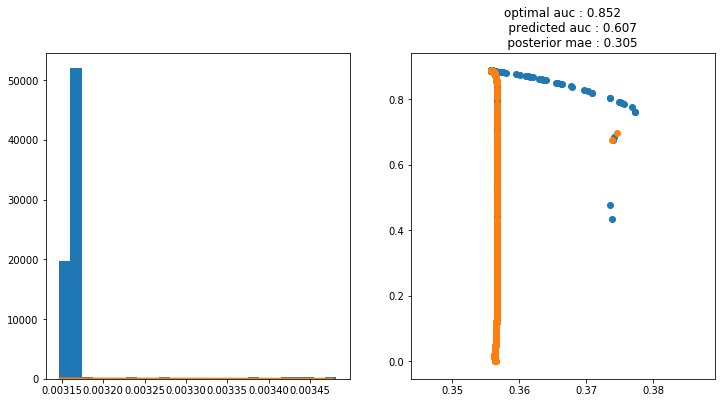


90/90 [==============================] - 1s 11ms/step - loss: 1.2337 - reconstruction_loss: 0.8346 - generative_loss: 0.0959 - discriminator_loss: 0.3044 - discriminator_auc: 0.5275


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


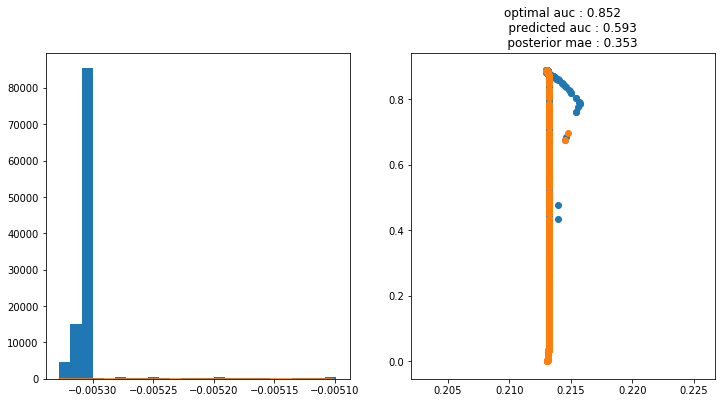


90/90 [==============================] - 1s 11ms/step - loss: 1.2421 - reconstruction_loss: 0.8349 - generative_loss: 0.0973 - discriminator_loss: 0.3033 - discriminator_auc: 0.5272


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


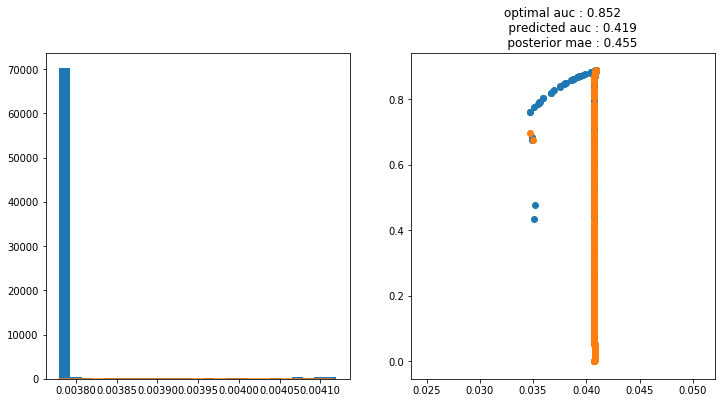


90/90 [==============================] - 1s 11ms/step - loss: 1.2269 - reconstruction_loss: 0.8347 - generative_loss: 0.0969 - discriminator_loss: 0.3059 - discriminator_auc: 0.5267


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


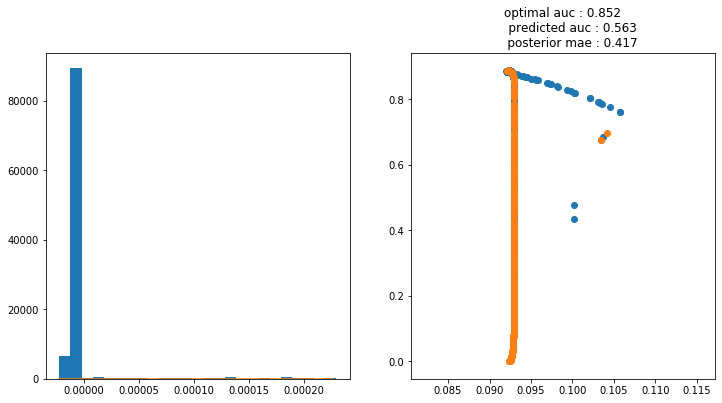


90/90 [==============================] - 1s 11ms/step - loss: 1.2310 - reconstruction_loss: 0.8347 - generative_loss: 0.0964 - discriminator_loss: 0.3069 - discriminator_auc: 0.5263


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


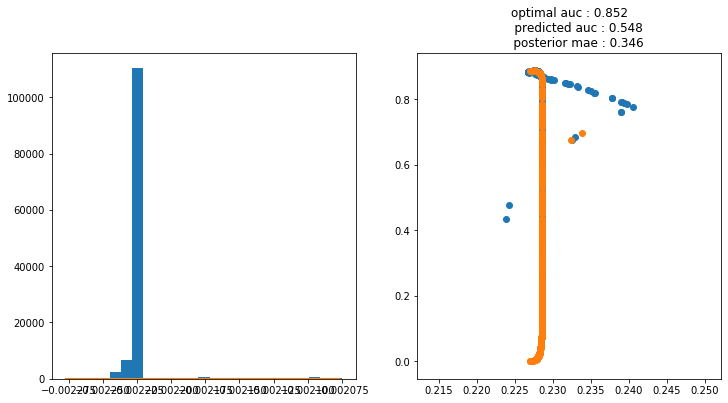


90/90 [==============================] - 1s 11ms/step - loss: 1.2356 - reconstruction_loss: 0.8346 - generative_loss: 0.0958 - discriminator_loss: 0.3052 - discriminator_auc: 0.5259


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


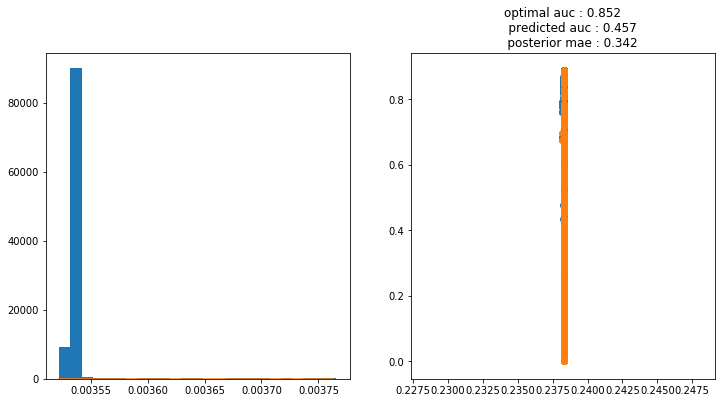


90/90 [==============================] - 1s 11ms/step - loss: 1.2354 - reconstruction_loss: 0.8348 - generative_loss: 0.0961 - discriminator_loss: 0.3037 - discriminator_auc: 0.5255


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


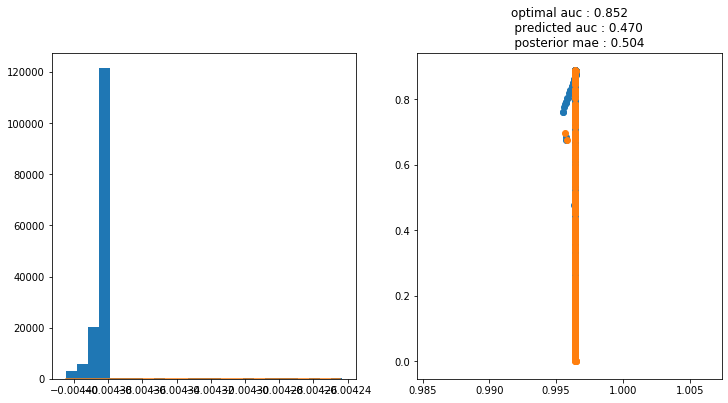


90/90 [==============================] - 1s 11ms/step - loss: 1.2373 - reconstruction_loss: 0.8347 - generative_loss: 0.0960 - discriminator_loss: 0.3035 - discriminator_auc: 0.5250


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


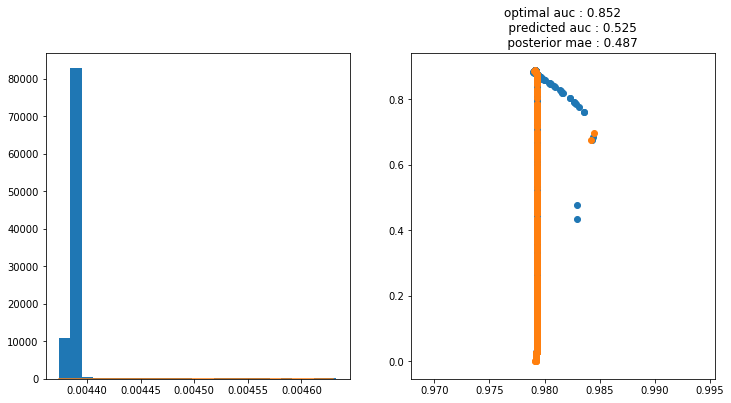


90/90 [==============================] - 1s 11ms/step - loss: 1.2418 - reconstruction_loss: 0.8347 - generative_loss: 0.0962 - discriminator_loss: 0.3034 - discriminator_auc: 0.5246


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


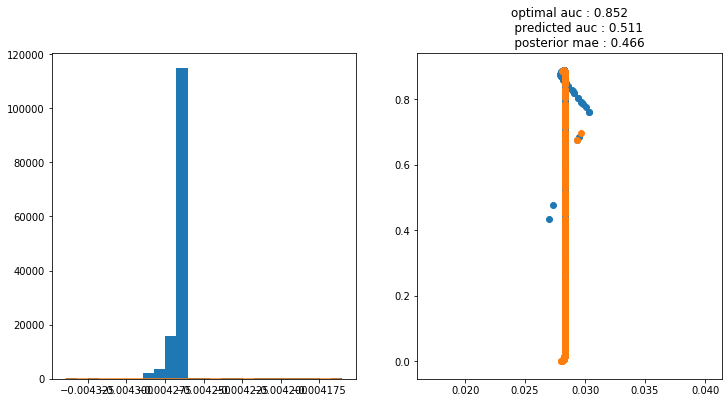


90/90 [==============================] - 1s 11ms/step - loss: 1.2357 - reconstruction_loss: 0.8347 - generative_loss: 0.0959 - discriminator_loss: 0.3042 - discriminator_auc: 0.5242


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


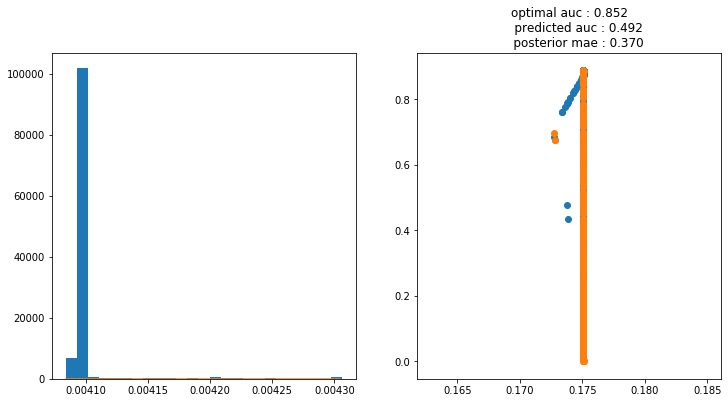


90/90 [==============================] - 1s 11ms/step - loss: 1.2350 - reconstruction_loss: 0.8349 - generative_loss: 0.0961 - discriminator_loss: 0.3038 - discriminator_auc: 0.5239


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


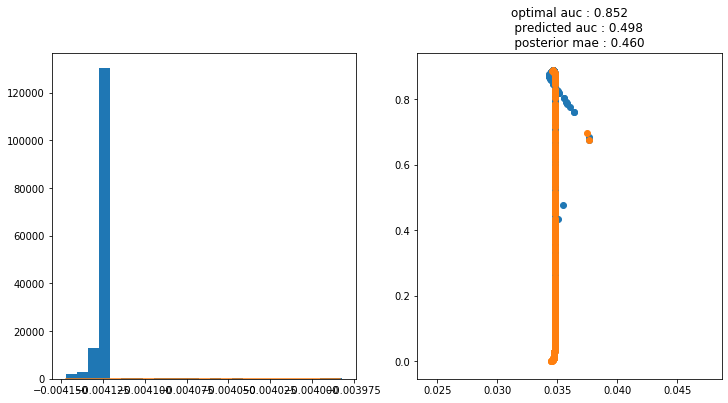


90/90 [==============================] - 1s 11ms/step - loss: 1.2410 - reconstruction_loss: 0.8345 - generative_loss: 0.0959 - discriminator_loss: 0.3040 - discriminator_auc: 0.5236


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


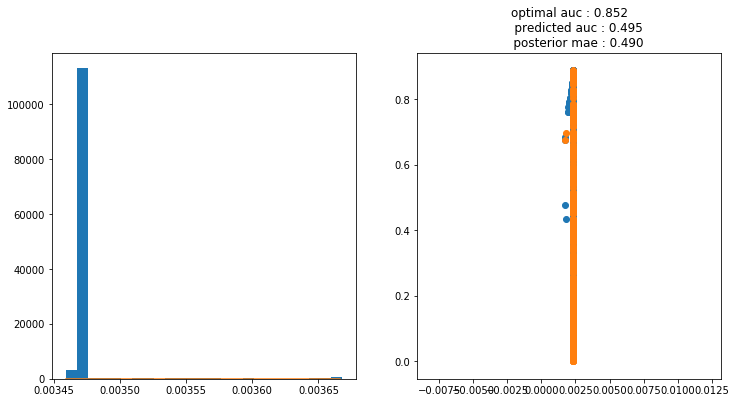


90/90 [==============================] - 1s 11ms/step - loss: 1.2382 - reconstruction_loss: 0.8347 - generative_loss: 0.0959 - discriminator_loss: 0.3042 - discriminator_auc: 0.5232


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


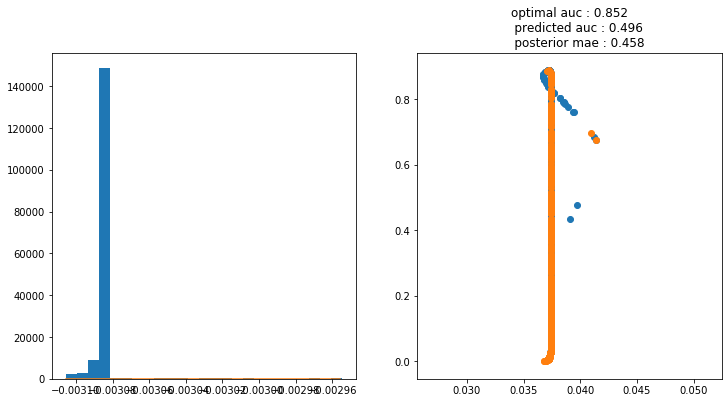


90/90 [==============================] - 1s 11ms/step - loss: 1.2339 - reconstruction_loss: 0.8346 - generative_loss: 0.0957 - discriminator_loss: 0.3045 - discriminator_auc: 0.5228


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


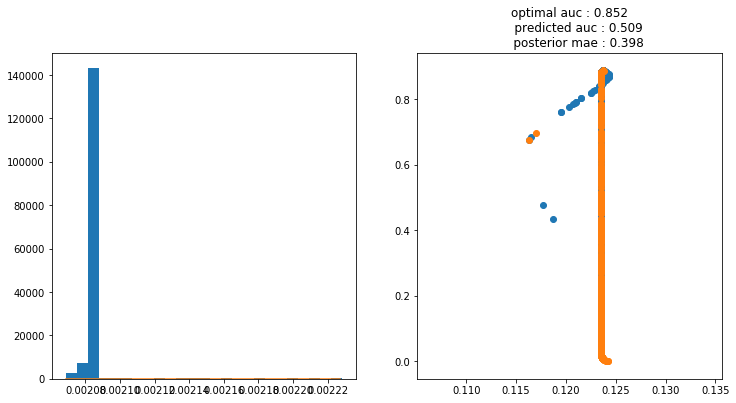


90/90 [==============================] - 1s 11ms/step - loss: 1.2344 - reconstruction_loss: 0.8347 - generative_loss: 0.0958 - discriminator_loss: 0.3050 - discriminator_auc: 0.5224


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


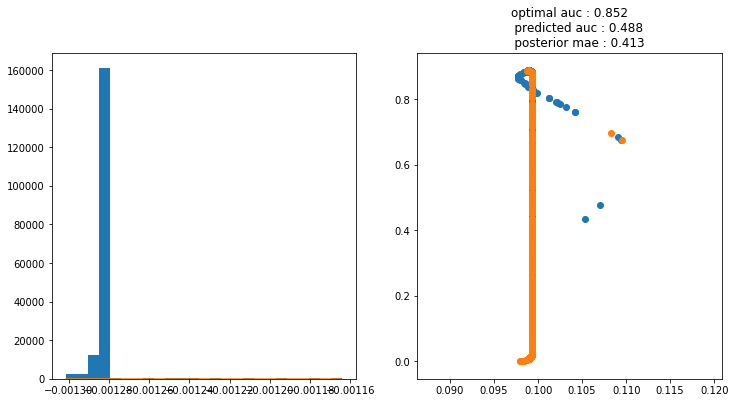


90/90 [==============================] - 1s 11ms/step - loss: 1.2317 - reconstruction_loss: 0.8346 - generative_loss: 0.0955 - discriminator_loss: 0.3056 - discriminator_auc: 0.5218


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


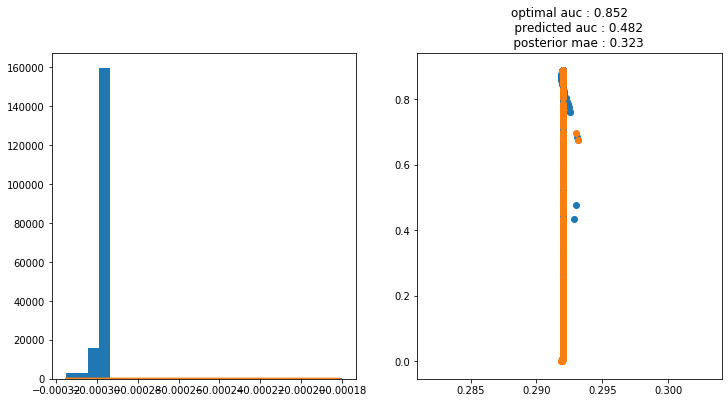


90/90 [==============================] - 1s 11ms/step - loss: 1.2414 - reconstruction_loss: 0.8349 - generative_loss: 0.0954 - discriminator_loss: 0.3061 - discriminator_auc: 0.5212


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


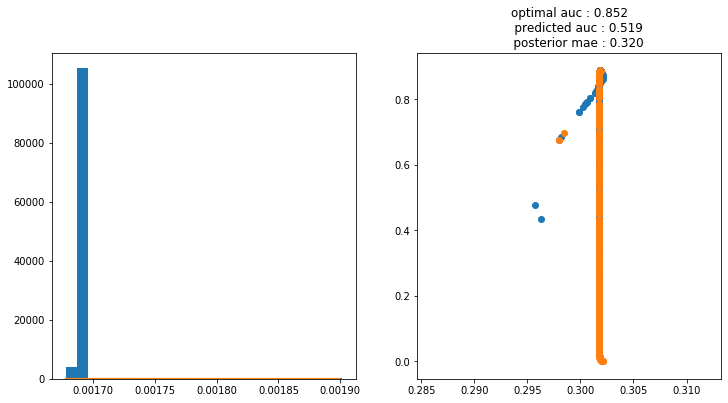


90/90 [==============================] - 1s 11ms/step - loss: 1.2307 - reconstruction_loss: 0.8348 - generative_loss: 0.0951 - discriminator_loss: 0.3060 - discriminator_auc: 0.5206


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


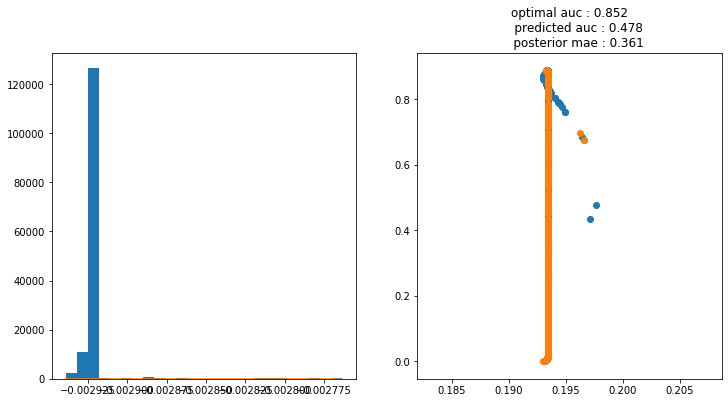


90/90 [==============================] - 1s 11ms/step - loss: 1.2217 - reconstruction_loss: 0.8347 - generative_loss: 0.0953 - discriminator_loss: 0.3052 - discriminator_auc: 0.5201


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


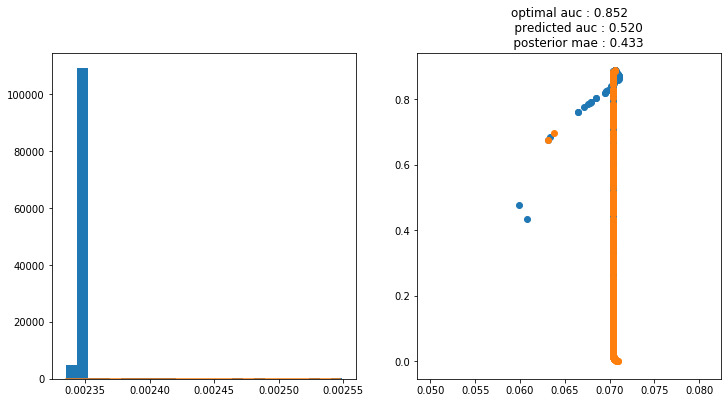


90/90 [==============================] - 1s 11ms/step - loss: 1.2350 - reconstruction_loss: 0.8346 - generative_loss: 0.0955 - discriminator_loss: 0.3049 - discriminator_auc: 0.5195


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


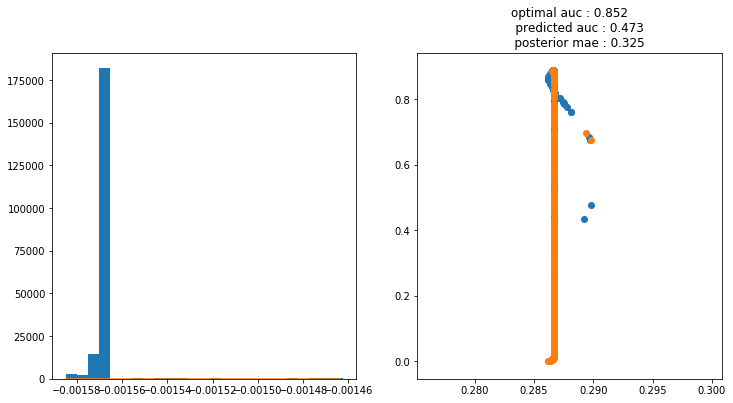


90/90 [==============================] - 1s 11ms/step - loss: 1.2403 - reconstruction_loss: 0.8350 - generative_loss: 0.0953 - discriminator_loss: 0.3052 - discriminator_auc: 0.5191


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


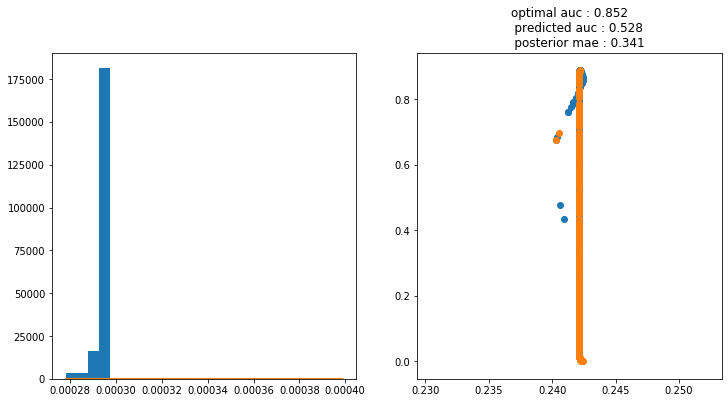


90/90 [==============================] - 1s 11ms/step - loss: 1.2293 - reconstruction_loss: 0.8348 - generative_loss: 0.0952 - discriminator_loss: 0.3057 - discriminator_auc: 0.5186


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


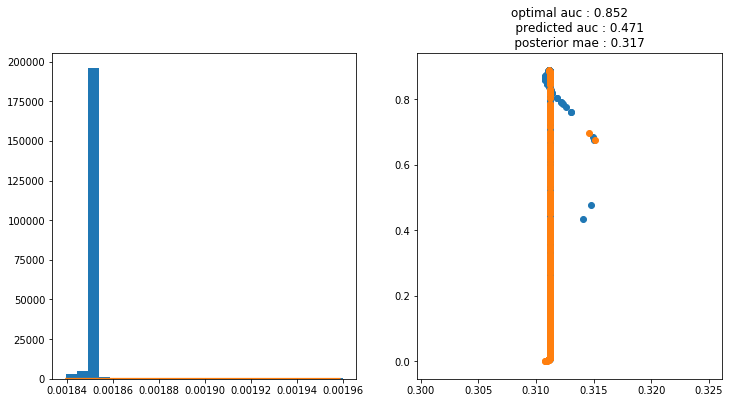


90/90 [==============================] - 1s 11ms/step - loss: 1.2284 - reconstruction_loss: 0.8346 - generative_loss: 0.0950 - discriminator_loss: 0.3057 - discriminator_auc: 0.5181


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


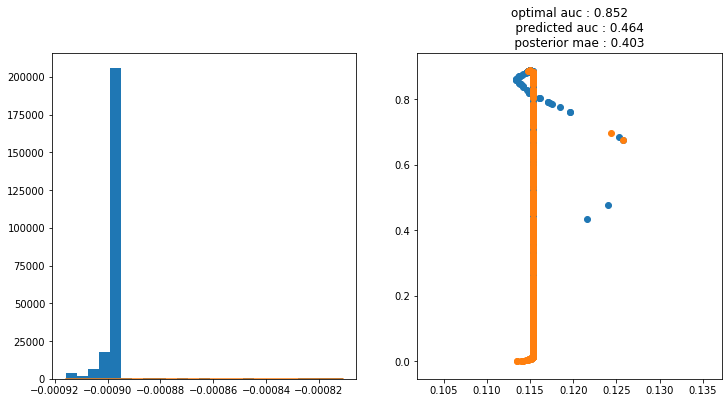


90/90 [==============================] - 1s 11ms/step - loss: 1.2351 - reconstruction_loss: 0.8347 - generative_loss: 0.0951 - discriminator_loss: 0.3054 - discriminator_auc: 0.5176


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


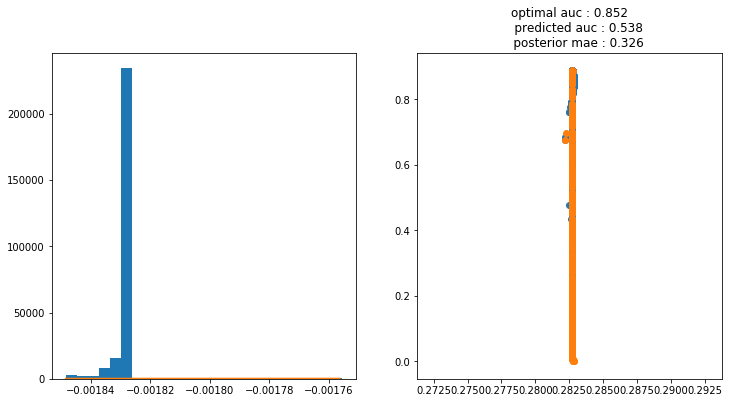


90/90 [==============================] - 1s 11ms/step - loss: 1.2430 - reconstruction_loss: 0.8350 - generative_loss: 0.0952 - discriminator_loss: 0.3052 - discriminator_auc: 0.5172


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


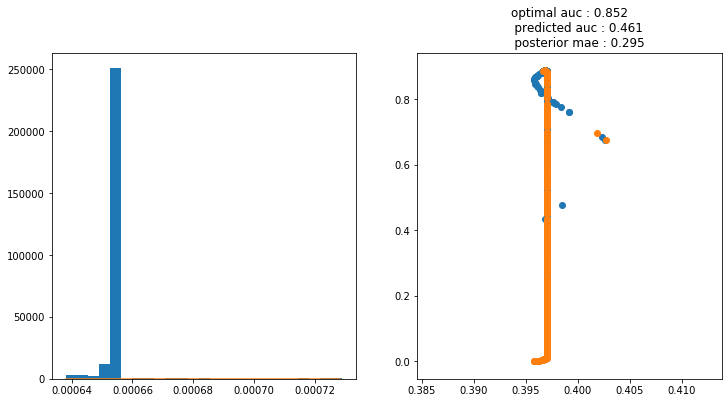


90/90 [==============================] - 1s 11ms/step - loss: 1.2365 - reconstruction_loss: 0.8347 - generative_loss: 0.0951 - discriminator_loss: 0.3055 - discriminator_auc: 0.5170


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


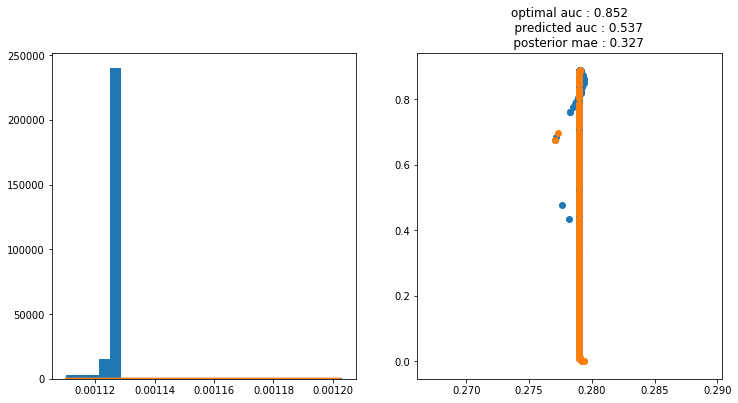


90/90 [==============================] - 1s 11ms/step - loss: 1.2276 - reconstruction_loss: 0.8347 - generative_loss: 0.0951 - discriminator_loss: 0.3054 - discriminator_auc: 0.5168


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


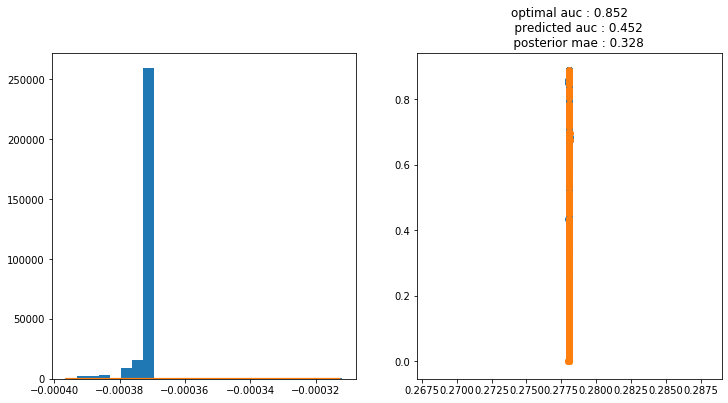


90/90 [==============================] - 1s 11ms/step - loss: 1.2384 - reconstruction_loss: 0.8349 - generative_loss: 0.0954 - discriminator_loss: 0.3050 - discriminator_auc: 0.5170


/home/dz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


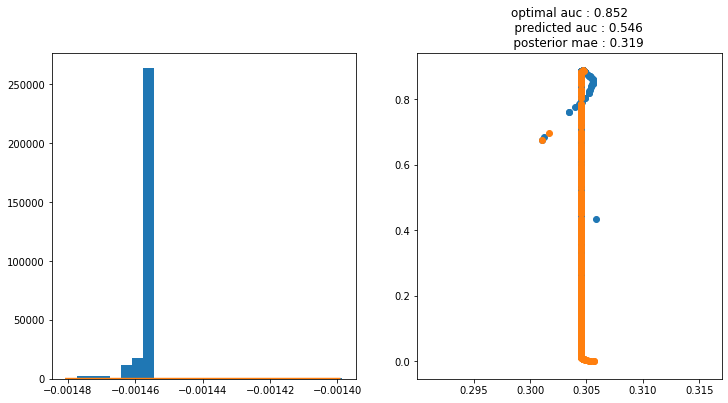

In [192]:
for epoch in range(100):
    em = MSGMM()
    embeddingsU = encoder.predict(xUnlabeledTrain)
    embeddingsU += np.random.normal(scale=.001,size=embeddingsU.shape)
    embeddingsP = encoder.predict(xPosTrain)
    embeddingsP += np.random.normal(scale=.001,size=embeddingsP.shape)
    em.fit(embeddingsU,embeddingsP,verbose=False)
    ae.m = np.stack((em.u1,
                     em.u0))
    ae.s = np.stack((em.sigma1,
                     em.sigma0))
    ae.alpha = em.alpha
    ae.fit(xUnlabeledTrain,epochs=1,batch_size=100,)
    fig,ax = plt.subplots(1,2,figsize=(12,6))
    if latent_dim == 2:
        ax[0].scatter(*encoder.predict(xUnlabeledVal[yPNVal]).T)
        ax[0].scatter(*encoder.predict(xUnlabeledVal[~yPNVal]).T,alpha=.5)
    elif latent_dim == 1:
        z = encoder.predict(xUnlabeledVal)
        ax[0].hist(z,density=True,bins=25)
        mix = Mixture([
            ss.multivariate_normal(em.u1,em.sigma1),
            ss.multivariate_normal(em.u0,em.sigma0),
        ],[em.alpha,1-em.alpha])
        rng = np.arange(z.min(),z.max(),(z.max() - z.min())/100)
        ax[0].plot(rng,mix.pdf(rng))
    predPost = em.predict_proba(encoder.predict(xUnlabeledVal))
    truePost = posterior(xUnlabeledVal)
    ax[1].scatter(predPost[yPNVal],truePost[yPNVal])
    ax[1].scatter(predPost[~yPNVal],truePost[~yPNVal])
    ax[1].set_title("optimal auc : {aucOpt:.3f}\n \
    predicted auc : {aucPred:.3f}\n \
    posterior mae : {postMAE:.3f}".format(aucOpt=roc_auc_score(yPNVal,
                                                               truePost),
                                          aucPred=roc_auc_score(yPNVal,
                                                                predPost),
                                          postMAE=np.mean(np.abs(truePost-predPost))))
    plt.show()

In [ ]:
if DIM == 1:
    plt.hist(xUnlabeled,density=False)

    plt.hist(xHat,density=False,alpha=.5)
elif DIM == 2:
    plt.scatter(*xUnlabeled.T)
    plt.scatter(*xHat.T)